In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sns
import statsmodels.api as sm 
from scipy.stats import skew, kurtosis 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics       import r2_score, mean_absolute_error
from sklearn.pipeline      import Pipeline
from sklearn.model_selection import cross_val_predict, KFold

/Users/xiongsimeng/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
merged=pd.read_csv("merged_exact_weight.csv")
merged.shape

/var/folders/nw/3jwfxsxs5hjf1kw6d5bq2bnw0000gn/T/ipykernel_15655/3995920293.py:1: DtypeWarning: Columns (133) have mixed types. Specify dtype option on import or set low_memory=False.
  merged=pd.read_csv("merged_exact_weight.csv")


(6079, 209)

In [3]:
# ─── 1) DICTS ────────────────────────────
brenner = {
    21: 410, 22: 480, 23: 530, 24: 640, 25: 740,
    26: 850, 27: 990, 28:1150, 29:1310, 30:1460,
    31:1630, 32:1810, 33:2010, 34:2220, 35:2430,
    36:2650, 37:2870, 38:3030, 39:3170, 40:3280,
    41:3360, 42:3410, 43:3420, 44:3390
}

who_general = {
    14:  90, 15: 114, 16: 144, 17: 179, 18: 222, 
    19: 272, 20: 330, 21: 398, 22: 476, 23: 565,
    24: 665, 25: 778, 26: 902, 27: 1039, 28: 1189,
    29: 1350, 30: 1523, 31: 1707, 32: 1901, 33: 2103,
    34: 2312, 35: 2527, 36: 2745, 37: 2966, 38: 3186,
    39: 3403, 40: 3617
}

who_female = {
    14:  89, 15: 113, 16: 141, 17: 176, 18: 217, 
    19: 266, 20: 322, 21: 388, 22: 464, 23: 551,
    24: 649, 25: 758, 26: 880, 27: 1014, 28: 1160,
    29: 1319, 30: 1489, 31: 1670, 32: 1861, 33: 2060,
    34: 2268, 35: 2481, 36: 2689, 37: 2917, 38: 3136,
    39: 3354, 40: 3567
}

who_male = {
    14:  92, 15: 116, 16: 146, 17: 183, 18: 226, 
    19: 277, 20: 337, 21: 407, 22: 487, 23: 578,
    24: 681, 25: 795, 26: 923, 27: 1063, 28: 1215,
    29: 1379, 30: 1555, 31: 1741, 32: 1937, 33: 2140,
    34: 2350, 35: 2565, 36: 2783, 37: 3001, 38: 3218,
    39: 3432, 40: 3639
}

intergrowth = {
    18: 216, 
    19: 263, 20: 318, 21: 381, 22: 454, 23: 537,
    24: 630, 25: 734, 26: 851, 27: 979, 28: 1119,
    29: 1272, 30: 1435, 31: 1610, 32: 1795, 33: 1988,
    34: 2189, 35: 2394, 36: 2602, 37: 2811, 38: 3017,
    39: 3217, 40: 3409, 41: 3588
}

## Interpolates 

In [4]:
# ─── A) Build an interpolation factory ───────────────────────────────────────
def make_interp(med_map):
    """Return a function f(gest_days) that linearly interpolates med_map."""
    weeks = np.array(sorted(med_map.keys()))            # [14,15,…]
    days  = weeks * 7                                   # [98,105,…] actual days
    meds  = np.array([med_map[w] for w in weeks])       # medians at those weeks

    return lambda gdays: np.interp(gdays, days, meds)   # vectorized interp

In [5]:
# ─── C) Interpolated version of predicted_bw ────────────────────────────────
def compute_predicted_bw_interp(row,mode):
    # pick the right interp‐function
    if mode == 'brenner':
        med_dict,f = brenner,interp_brenner
    elif mode == 'who_general':
        med_dict,f = who_general,interp_who_general
    elif mode == 'intergrowth':
        med_dict,f = intergrowth,interp_intergrowth
    elif mode == 'who_sex':
        if row['sex_of_inf'] == '2:Female':
            med_dict,f = who_female, interp_who_female
        elif row['sex_of_inf'] == '1:Male':
            med_dict,f = who_male,interp_who_male
        else:
            return pd.NA
    else:
        return pd.NA
    
    # handle missing f_weight
    if pd.isna(row['f_weight']) or row['f_weight'] == 0:
        return pd.NA

    # compute the valid day‐range from med_dict
    min_wk, max_wk = min(med_dict), max(med_dict)
    min_day, max_day = min_wk * 7, max_wk * 7

    # if either day is out of range, return NA
    if not (min_day <= row['ultra_days'] <= max_day) or not (min_day <= row['deliv_days'] <= max_day):
        return pd.NA

    # get the median at the exact day
    med_u = f(row['ultra_days'])
    med_d = f(row['deliv_days'])
    
    # formula
    return int(med_d * row['f_weight'] / med_u)


## Filter the valid Data

In [6]:
# create one interp‐func per table
interp_brenner    = make_interp(brenner)
interp_who_general= make_interp(who_general)
interp_who_female = make_interp(who_female)
interp_who_male   = make_interp(who_male)
interp_intergrowth   = make_interp(intergrowth)

# ─── B) Parse your “best” col into absolute days ────────────────────────────
# e.g. “36w 5d” → 36*7 + 5 = 257 days
parsed = merged['best'].str.extract(r'(?P<wk>\d+)\s*[wW]\s*(?P<d>\d+)\s*[dD]', expand=True)
merged['ultra_days'] = parsed['wk'].astype(int)*7 + parsed['d'].astype(int)

# your delivery days are already in merged['gestday']
merged['deliv_days'] = merged['gestday'].replace(999, np.nan)

merged.shape

(6079, 211)

In [7]:
merged['ultra_days'].isna().sum()

0

Text(0.5, 1.0, 'Distribution of gestational age of Ultrasound (days)')

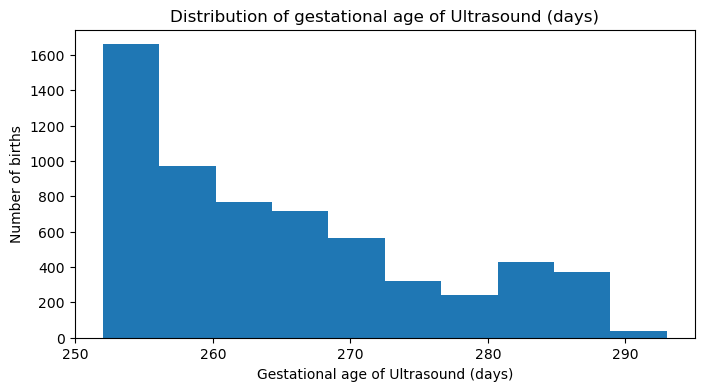

In [8]:
plt.figure(figsize=(8, 4))
plt.hist(merged["ultra_days"])      
plt.xlabel('Gestational age of Ultrasound (days)')
plt.ylabel('Number of births')
plt.title('Distribution of gestational age of Ultrasound (days)')

In [9]:
(merged['gestday'] == 999).sum()

618

In [10]:
merged['deliv_days'].isna().sum()

618

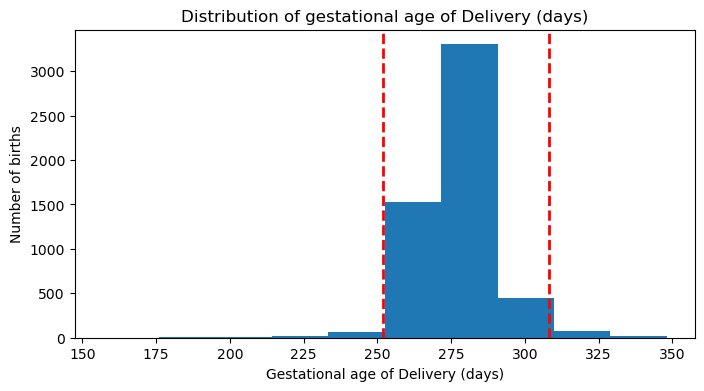

In [11]:
plt.figure(figsize=(8, 4))
plt.hist(merged['deliv_days'])        # 7-day bins ≈ 1 week
plt.xlabel('Gestational age of Delivery (days)')
plt.ylabel('Number of births')
plt.title('Distribution of gestational age of Delivery (days)')
plt.axvline(252, color='red', linestyle='--', linewidth=2)
plt.axvline(308, color='red', linestyle='--', linewidth=2)

In [12]:
(merged['gestday'] < 252).sum()

83

In [13]:
(merged['gestday'] > 308).sum()

719

In [14]:
((merged['gestday'] > 252) & (merged['gestday'] < 308)).sum()

5260

In [15]:
merged['f_weight'].isna().sum()

167

In [16]:
merged['ga_diff_days'] = merged['deliv_days'] - merged['ultra_days']

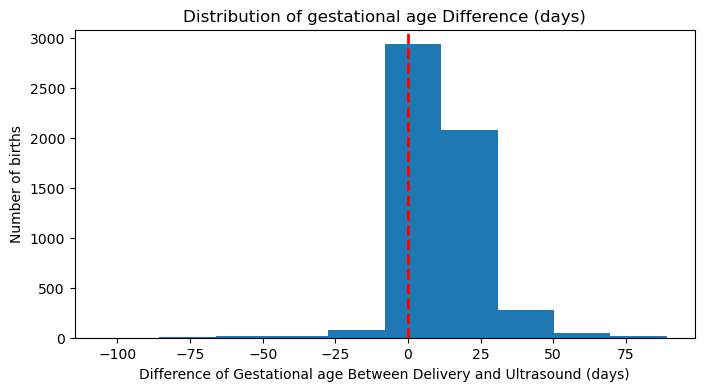

In [17]:
plt.figure(figsize=(8, 4))
plt.hist(merged['ga_diff_days'])  
plt.xlabel('Difference of Gestational age Between Delivery and Ultrasound (days)')
plt.ylabel('Number of births')
plt.title('Distribution of gestational age Difference (days)')
plt.axvline(0, color='red', linestyle='--', linewidth=2)

In [18]:
(merged['ga_diff_days'] >= 0).sum()

5187

In [19]:
(merged['ga_diff_days'] < 0).sum()

274

In [20]:
outlier_mask = merged['ga_diff_days'] < 0
outliers = merged.loc[
    outlier_mask,
    ['MRN', 'f_weight', 'gestday',
     'deliv_days', 'ultra_days', 'ga_diff_days',
     'best', 'birth_wgt']
].copy()
outliers = outliers.sort_values('ga_diff_days', ascending=False)
print(outliers.shape)
outliers.head(20)

(274, 8)


,MRN,f_weight,gestday,deliv_days,ultra_days,ga_diff_days,best,birth_wgt
4439,E368930,3833.0,277,277.0,278,-1.0,39w 5d,3770
5231,E626279,NaN,251,251.0,252,-1.0,36w 0d,2440
1114,E1381418,2793.0,254,254.0,255,-1.0,36w 3d,3175
1724,E183435,3242.0,266,266.0,267,-1.0,38w 1d,2910
870,E1224944,3243.0,282,282.0,283,-1.0,40w 3d,3400
2572,E2413055,3849.0,282,282.0,283,-1.0,40w 3d,3750
751,E1166569,3653.0,251,251.0,252,-1.0,36w 0d,3820
3148,E2661186,2958.0,266,266.0,267,-1.0,38w 1d,3110
3170,E2668572,4253.0,276,276.0,277,-1.0,39w 4d,4010
3447,E289081,2841.0,261,261.0,262,-1.0,37w 3d,3005


In [21]:
outliers['ga_diff_days'].describe()

count    274.000000
mean     -13.795620
std       17.168691
min     -105.000000
25%      -16.750000
50%       -7.000000
75%       -4.000000
max       -1.000000
Name: ga_diff_days, dtype: float64

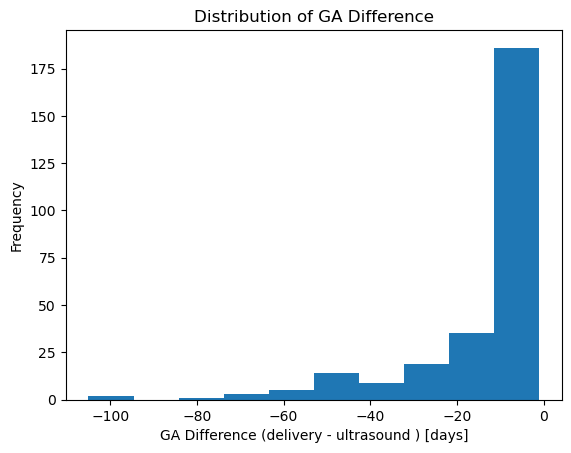

In [22]:
diffs = outliers['ga_diff_days'].dropna()
plt.figure()
plt.hist(diffs)
plt.xlabel('GA Difference (delivery - ultrasound ) [days]')
plt.ylabel('Frequency')
plt.title('Distribution of GA Difference')
plt.show()

In [23]:
# --- 0)  baseline ------------------------------------------------------------
df0 = merged.copy()
n0  = len(df0)
print(f"START: {n0:,} rows")

# --- 1)  GA < 44 wk (308 d) --------------------------------------------------
mask1 = (df0['deliv_days'] <= 308) & (df0['ultra_days'] <= 308)
df1   = df0.loc[mask1]
d1    = n0 - len(df1)
print(f"STEP 1  (GA < 44 wk):  dropped {d1:,} rows → {len(df1):,}")

# --- 2)  delivery ≥ ultrasound ----------------------------------------------
mask2 = df1['deliv_days'] >= df1['ultra_days']
df2   = df1.loc[mask2]
d2    = len(df1) - len(df2)
print(f"STEP 2  (deliv ≥ ultra): dropped {d2:,} rows → {len(df2):,}")

# --- 3)  drop NAs in key columns --------------------------------------------
cols_na = ['f_weight', 'deliv_days', 'ultra_days']
df3     = df2.dropna(subset=cols_na)
d3      = len(df2) - len(df3)

# Detailed NA counts for curiosity
na_counts = df2[cols_na].isna().sum()

print(f"STEP 3  (drop NAs):        dropped {d3:,} rows → {len(df3):,}")
print("          └─ broken down by column:")
for c, n in na_counts.items():
    print(f"             • missing {c:<11}: {n:,}")

# df3 is your final cleaned DataFrame


START: 6,079 rows
STEP 1  (GA < 44 wk):  dropped 719 rows → 5,360
STEP 2  (deliv ≥ ultra): dropped 274 rows → 5,086
STEP 3  (drop NAs):        dropped 141 rows → 4,945
          └─ broken down by column:
             • missing f_weight   : 141
             • missing deliv_days : 0
             • missing ultra_days : 0


In [24]:
merged = (
    merged
        .loc[(merged['deliv_days']   <= 308) & 
           (merged['ultra_days']   <= 308)]
        .loc[(merged['deliv_days'] >= merged['ultra_days'])]   # rule 1
      .dropna(subset=['f_weight', 'deliv_days'])             # rules 2 & 3
      .copy()
)
merged.shape

(4945, 212)

In [25]:
n_single = (merged['plurality'] == "1:Single").sum()
n_single
n_single_mrns = merged.loc[merged['plurality'] == "1:Single", 'MRN'].nunique()
n_single_mrns

4770

In [26]:
mask_twins = merged['plurality'] == "2:Twin"
n_twin_mrns = merged.loc[mask_twins, 'MRN'].nunique()
n_twin_mrns

89

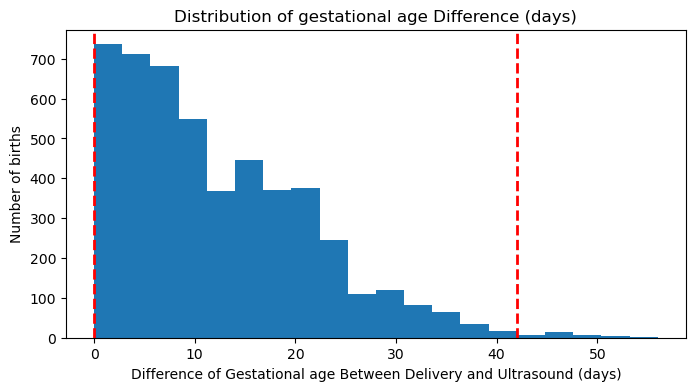

In [27]:
plt.figure(figsize=(8, 4))
plt.hist(merged['ga_diff_days'],bins=20)  
plt.xlabel('Difference of Gestational age Between Delivery and Ultrasound (days)')
plt.ylabel('Number of births')
plt.title('Distribution of gestational age Difference (days)')
plt.axvline(0, color='red', linestyle='--', linewidth=2)
plt.axvline(42, color='red', linestyle='--', linewidth=2)

In [28]:
(merged['ga_diff_days'] > 42).sum()

32

In [29]:
merged['ga_diff_days'].max()  

56.0

In [30]:
merged = merged[merged["plurality"] == "1:Single"]
merged

,MRN,Date___Time,hospcode,reszip5,sex_of_inf,plurality,birth_orde,birth_wgt,mom_medrec,mom_whi,...,Other Rare or Miscellaneous,Placenta & Cord Conditions,Poor Fetal Growth,Prenatal Care & Follow‑Up,Reproductive Technology & Multiples,Trauma & External Injury,indications,ultra_days,deliv_days,ga_diff_days
0,006520,2015-03-03,Highland,14607.0,1:Male,1:Single,single,3754,006520,1:Yes,...,0,0,0,0,0,0,"breech presentation suspected, not found",257,285.0,28.0
1,008177,2014-01-31,Highland,14620.0,2:Female,1:Single,single,3419,008177,1:Yes,...,0,0,0,0,0,0,bicornuate uterus; size greater than dates,252,282.0,30.0
2,018533,2014-06-03,Highland,14618.0,1:Male,1:Single,single,3538,018533,1:Yes,...,0,0,0,0,0,0,bleeding before 22 weeks; size greater than dates,265,266.0,1.0
3,020567,2015-02-26,Highland,14586.0,2:Female,1:Single,single,2929,020567,1:Yes,...,0,0,0,0,0,0,size less than dates,273,283.0,10.0
4,023246,2015-04-15,Highland,14624.0,1:Male,1:Single,single,4250,023246,0:No,...,0,1,0,0,0,0,post dates; 2 vessel umbilical cord; choroid p...,286,301.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6072,E996508,2023-01-05,Strong,14450.0,1:Male,1:Single,single,3160,E996508,1:Yes,...,0,0,1,0,0,0,medication use in pregnancy (single pregnancy)...,258,285.0,27.0
6074,E996890,2023-05-19,Strong,14623.0,2:Female,1:Single,single,3110,E996890,0:No,...,0,0,0,0,0,0,"hypertension, chronic, 3rd tri",265,270.0,5.0
6075,E996991,2021-11-03,Strong,14534.0,2:Female,1:Single,single,3240,E996991,1:Yes,...,0,0,0,0,0,0,"advanced maternal age, multigravida, 3rd tri; ...",262,266.0,4.0
6076,E998249,2020-04-22,Strong,14428.0,2:Female,1:Single,single,3960,E998249,1:Yes,...,0,0,0,0,0,0,"adult bmi 38.0-38.9; gestational diabetes, uns...",261,283.0,22.0


In [31]:
merged = merged.loc[merged["deliv_days"] <= 294].copy()
merged 

,MRN,Date___Time,hospcode,reszip5,sex_of_inf,plurality,birth_orde,birth_wgt,mom_medrec,mom_whi,...,Other Rare or Miscellaneous,Placenta & Cord Conditions,Poor Fetal Growth,Prenatal Care & Follow‑Up,Reproductive Technology & Multiples,Trauma & External Injury,indications,ultra_days,deliv_days,ga_diff_days
0,006520,2015-03-03,Highland,14607.0,1:Male,1:Single,single,3754,006520,1:Yes,...,0,0,0,0,0,0,"breech presentation suspected, not found",257,285.0,28.0
1,008177,2014-01-31,Highland,14620.0,2:Female,1:Single,single,3419,008177,1:Yes,...,0,0,0,0,0,0,bicornuate uterus; size greater than dates,252,282.0,30.0
2,018533,2014-06-03,Highland,14618.0,1:Male,1:Single,single,3538,018533,1:Yes,...,0,0,0,0,0,0,bleeding before 22 weeks; size greater than dates,265,266.0,1.0
3,020567,2015-02-26,Highland,14586.0,2:Female,1:Single,single,2929,020567,1:Yes,...,0,0,0,0,0,0,size less than dates,273,283.0,10.0
5,028300,2015-03-26,Highland,14425.0,1:Male,1:Single,single,4278,028300,1:Yes,...,0,0,0,0,0,0,post dates,285,291.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6072,E996508,2023-01-05,Strong,14450.0,1:Male,1:Single,single,3160,E996508,1:Yes,...,0,0,1,0,0,0,medication use in pregnancy (single pregnancy)...,258,285.0,27.0
6074,E996890,2023-05-19,Strong,14623.0,2:Female,1:Single,single,3110,E996890,0:No,...,0,0,0,0,0,0,"hypertension, chronic, 3rd tri",265,270.0,5.0
6075,E996991,2021-11-03,Strong,14534.0,2:Female,1:Single,single,3240,E996991,1:Yes,...,0,0,0,0,0,0,"advanced maternal age, multigravida, 3rd tri; ...",262,266.0,4.0
6076,E998249,2020-04-22,Strong,14428.0,2:Female,1:Single,single,3960,E998249,1:Yes,...,0,0,0,0,0,0,"adult bmi 38.0-38.9; gestational diabetes, uns...",261,283.0,22.0


In [32]:
merged["deliv_days"].min()

252.0

In [33]:
merged["deliv_days"].max()

294.0

## Brenner

In [34]:
merged['predicted_bw_brenner'] = merged.apply(compute_predicted_bw_interp, axis=1,args=('brenner',)).astype("Int64")

In [35]:
print( merged['predicted_bw_brenner'].describe() )

count         4568.0
mean     3475.149956
std       512.030668
min           1719.0
25%          3143.75
50%           3469.0
75%           3810.0
max           5915.0
Name: predicted_bw_brenner, dtype: Float64


In [36]:
merged["error_brenner"] = (merged['predicted_bw_brenner'] - merged['birth_wgt'])
merged["error_brenner"].describe()

count        4568.0
mean     104.587785
std      273.469145
min         -1054.0
25%           -69.0
50%           109.0
75%           282.0
max          1288.0
Name: error_brenner, dtype: Float64

In [37]:
merged['abs_error_brenner'] = (merged['predicted_bw_brenner'] - merged['birth_wgt']).abs()
merged['abs_error_brenner'].describe()

count        4568.0
mean     230.783494
std      180.149076
min             0.0
25%            90.0
50%           191.0
75%           331.0
max          1288.0
Name: abs_error_brenner, dtype: Float64

In [38]:
merged['pct_error_brenner'] = (merged['predicted_bw_brenner'] - merged['birth_wgt']) / merged['birth_wgt'] * 100
merged["pct_error_brenner"].describe()

count       4568.0
mean      3.521513
std       8.262104
min     -25.576208
25%      -2.018726
50%       3.250246
75%       8.686669
max      44.490501
Name: pct_error_brenner, dtype: Float64

In [39]:
merged['abs_pct_error_brenner']= ((merged['predicted_bw_brenner'] - merged['birth_wgt']) / merged['birth_wgt'] * 100).abs()
merged['abs_pct_error_brenner'].describe()

count       4568.0
mean      7.000995
std       5.625074
min            0.0
25%       2.655738
50%       5.737818
75%       10.02662
max      44.490501
Name: abs_pct_error_brenner, dtype: Float64

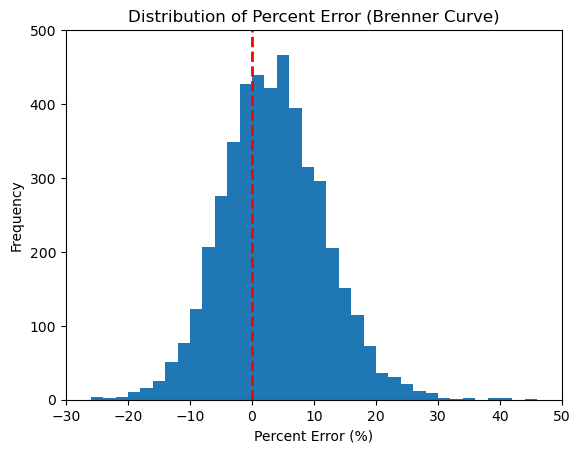

In [40]:
errors = merged['pct_error_brenner'].dropna()
bins = np.arange(-30, 52, 2)
xlim = (-30, 50)
ylim = (0, 500)
# plot histogram
plt.figure()
plt.hist(errors, bins=bins)
plt.xlabel('Percent Error (%)')
plt.ylabel('Frequency')
plt.title('Distribution of Percent Error (Brenner Curve)')
plt.axvline(0, color='red', linestyle='--', linewidth=2)
plt.xlim(xlim)                       # ← lock x-scale
plt.ylim(ylim)                       # ← lock y-scale
plt.show()

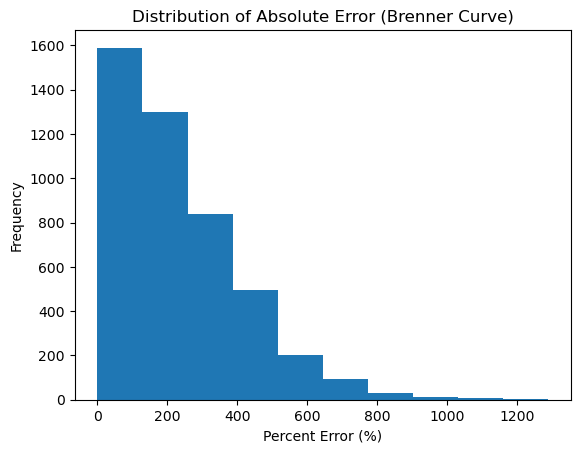

In [41]:
errors = merged['abs_error_brenner'].dropna()
# plot histogram
plt.figure()
plt.hist(errors)
plt.xlabel('Percent Error (%)')
plt.ylabel('Frequency')
plt.title('Distribution of Absolute Error (Brenner Curve)')
plt.show()

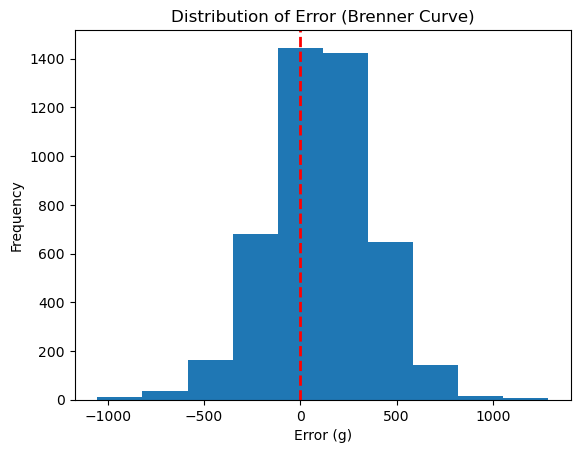

In [42]:
errors = merged['error_brenner'].dropna()
# plot histogram
plt.figure()
plt.hist(errors)
plt.xlabel('Error (g)')
plt.ylabel('Frequency')
plt.title('Distribution of Error (Brenner Curve)')
plt.axvline(0, color='red', linestyle='--', linewidth=2)
plt.show()

/Users/xiongsimeng/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


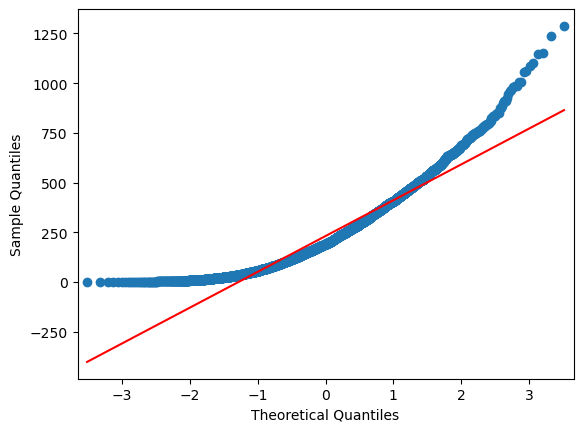

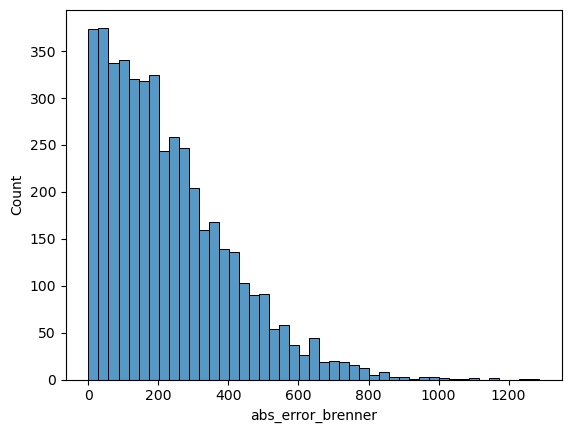

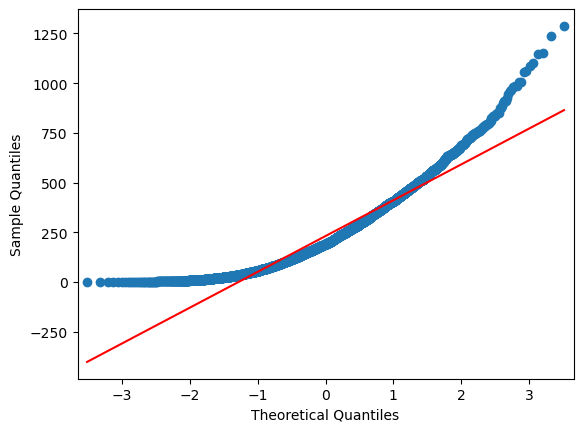

In [43]:
sns.histplot(merged["abs_error_brenner"])
sm.qqplot(merged["abs_error_brenner"], line="s")

/Users/xiongsimeng/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


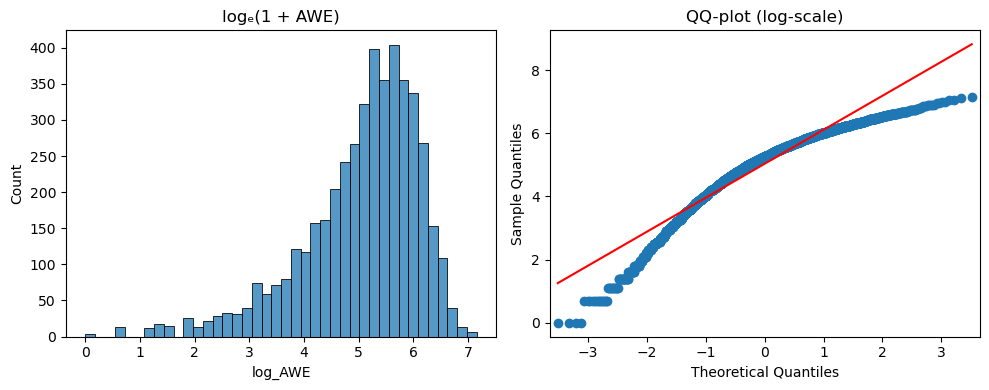

In [44]:
merged["log_AWE"] = np.log1p(merged["abs_error_brenner"])

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.histplot(merged["log_AWE"].dropna(), bins=40, ax=ax[0])
ax[0].set_title("logₑ(1 + AWE)")

sm.qqplot(merged["log_AWE"].dropna(), line="s", ax=ax[1])
ax[1].set_title("QQ-plot (log-scale)")
plt.tight_layout()

## Macrosomia

In [45]:
p_macrosomia = (merged['predicted_bw_brenner'] > 4000).mean() * 100
p_macrosomia_n = (merged['predicted_bw_brenner'] > 4000).sum()
print(p_macrosomia_n, f"{p_macrosomia:.2f}%")

685 15.00%


In [46]:
a_macrosomia = (merged['birth_wgt'] > 4000).mean() * 100
a_macrosomia_n = (merged['birth_wgt'] > 4000).sum()
print(a_macrosomia_n, f"{a_macrosomia:.2f}%")

495 10.84%


In [47]:
# % of babies predicted macro- but actually not macro-
fp_pct = ((merged['predicted_bw_brenner'] > 4000) & (merged['birth_wgt'] <= 4000)).mean() * 100
fp_n = ((merged['predicted_bw_brenner'] > 4000) & (merged['birth_wgt'] <= 4000)).sum()
print(fp_n, f"{fp_pct:.2f}%")

333 7.29%


## LGA

In [48]:
p90_girls_Fenton = {
    22:  619, 23:  704, 24:  796, 25:  912, 26: 1051,
    27: 1194, 28: 1363, 29: 1554, 30: 1772, 31: 2010,
    32: 2275, 33: 2540, 34: 2819, 35: 3081, 36: 3320
}

p90_boys_Fenton = {
    22:  644, 23:  741, 24:  853, 25:  972, 26: 1112,
    27: 1273, 28: 1442, 29: 1633, 30: 1846, 31: 2073,
    32: 2354, 33: 2641, 34: 2885, 35: 3152, 36: 3417,
}


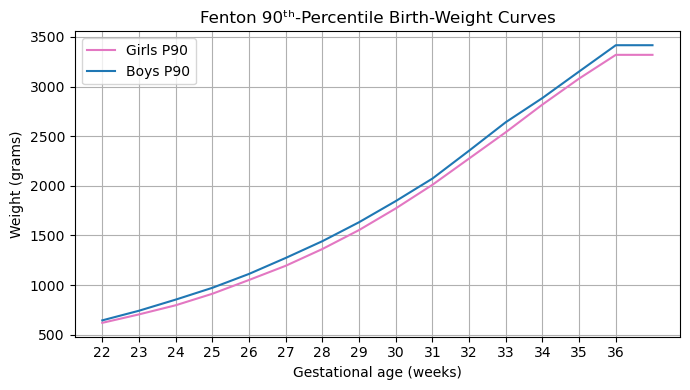

In [49]:
curve_girls_Fenton = make_interp(p90_girls_Fenton)
curve_boys_Fenton  = make_interp(p90_boys_Fenton)

# -----------------------------------------------------------
# 1.  Build an array of GA *days* that matches the dictionary
# -----------------------------------------------------------
ga_days = np.arange(22*7, 37*7 + 1)     # 22+0  …  37+0

girls_pred = curve_girls_Fenton(ga_days)
boys_pred  = curve_boys_Fenton(ga_days)

# -----------------------------------------------------------
# 2.  Plot lines AND points in *weeks*
# -----------------------------------------------------------
plt.figure(figsize=(7,4))

# lines
plt.plot(ga_days/7, girls_pred, label="Girls P90", color="tab:pink")
plt.plot(ga_days/7, boys_pred,  label="Boys P90",  color="tab:blue")

plt.xticks(range(22, 37))              # 22 – 37 w
plt.xlabel("Gestational age (weeks)")
plt.ylabel("Weight (grams)")
plt.title("Fenton 90ᵗʰ-Percentile Birth-Weight Curves")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [50]:
import xlwings as xw
from pathlib import Path

WB_PATH = Path("bwtPercentileCalculator.xlsx")
SHEET   = "Birthweight_all_percent"   # UI sheet name

# Cell addresses *in your file*:
CELL_GA_WK   = "D6"      # gestational weeks
CELL_GA_DAY  = "D7"      # gestational days
CELL_FEMALE  = "D11"
CELL_MALE    = "D12"
CELL_P90_OUT = "D24"     # the green 90th-centile cell (verify in Excel!)

with xw.App(visible=False) as app:
    wb  = app.books.open(WB_PATH)
    sht = wb.sheets[SHEET]

    p90_girls, p90_boys = {}, {}

    for week in range(37, 43):         # 37–42
        day_iter = [0] if week == 42 else range(0, 7)   # only 0-d for week 42
        for day in day_iter:
            ga_total = 7 * week + day
            # ---------- FEMALE ----------
            sht[CELL_GA_WK].value  = week
            sht[CELL_GA_DAY].value = day
            sht[CELL_FEMALE].value, sht[CELL_MALE].value = "x", ""
            app.calculate()                                 # <-- force recalc
            val = sht[CELL_P90_OUT].value
            if val is None:
                raise ValueError(f"Blank at {week}+{day} d (female)")
            p90_girls[ga_total] = round(val)

            # ---------- MALE ------------
            sht[CELL_FEMALE].value, sht[CELL_MALE].value = "", "x"
            app.calculate()
            val = sht[CELL_P90_OUT].value
            if val is None:
                raise ValueError(f"Blank at {week}+{day} d (male)")
            p90_boys[ga_total] = round(val)

print("Female 37 + 1 d P90 →", p90_girls[7*38+1])  # should print 3222
print("Male   37 + 1 d P90 →", p90_boys [7*37+1])


Female 37 + 1 d P90 → 3487
Male   37 + 1 d P90 → 3481


In [51]:
print(p90_girls)

{259: 3181, 260: 3222, 261: 3262, 262: 3302, 263: 3340, 264: 3378, 265: 3415, 266: 3451, 267: 3487, 268: 3521, 269: 3555, 270: 3588, 271: 3620, 272: 3651, 273: 3682, 274: 3711, 275: 3740, 276: 3768, 277: 3795, 278: 3821, 279: 3847, 280: 3871, 281: 3895, 282: 3918, 283: 3940, 284: 3962, 285: 3982, 286: 4002, 287: 4021, 288: 4039, 289: 4056, 290: 4073, 291: 4088, 292: 4103, 293: 4117, 294: 4130}


In [52]:
# ----------------------------------------------------------
# 0. Booleans we will reuse
# ----------------------------------------------------------
term_mask  = merged["deliv_days"] >= 37*7          # GA ≥ 37 weeks
male_mask  = merged["sex_of_inf"] == "male"        # infant is male

merged["wt_p90_a"] = np.nan

# ----------------------------------------------------------
# 1. TERM   +   MALE   → WHO dictionary (boys)
# ----------------------------------------------------------
idx =  term_mask  &  male_mask
merged.loc[idx, "wt_p90_a"] = merged.loc[idx, "deliv_days"].map(p90_boys)

# ----------------------------------------------------------
# 2. TERM   +   FEMALE → WHO dictionary (girls)
# ----------------------------------------------------------
idx =  term_mask  & ~male_mask
merged.loc[idx, "wt_p90_a"] = merged.loc[idx, "deliv_days"].map(p90_girls)

# ----------------------------------------------------------
# 3. PRETERM + MALE   → Fenton interpolator (boys)
# ----------------------------------------------------------
idx = ~term_mask &  male_mask
merged.loc[idx, "wt_p90_a"] = curve_boys_Fenton(merged.loc[idx, "deliv_days"])

# ----------------------------------------------------------
# 4. PRETERM + FEMALE → Fenton interpolator (girls)
# ----------------------------------------------------------
idx = ~term_mask & ~male_mask
merged.loc[idx, "wt_p90_a"] = curve_girls_Fenton(merged.loc[idx, "deliv_days"])

In [53]:
# Number of actual LGA 
merged["LGA_actual"] = (merged["birth_wgt"] > merged["wt_p90_a"]).astype("int8")

a_lga_n = merged["LGA_actual"].sum()
a_lga   = merged["LGA_actual"].mean()*100
print(a_lga_n, f"{a_lga:.2f}%")

902 19.75%


In [54]:
# Number of predicted LGA 
merged["LGA_predicted"] = (merged["predicted_bw_brenner"] > merged["wt_p90_a"]).astype("int8")

p_lga_n = merged["LGA_predicted"].sum()
p_lga   = merged["LGA_predicted"].mean()*100
print(p_lga_n, f"{p_lga:.2f}%")

1181 25.85%


In [55]:
# % of babies predicted lga- but actually not lga-
merged["LGA_false_pos"] = np.where(
    (merged["LGA_predicted"] == 1) & (merged["LGA_actual"] == 0), 1, 0
)

fp_n   = merged["LGA_false_pos"].sum()
fp_pct = fp_n / len(merged) * 100          # percent of *all* babies
print(fp_n, f"{fp_pct:.2f}%")

469 10.27%


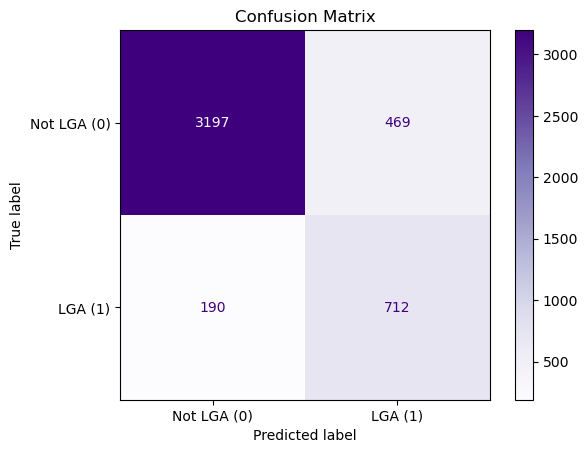

In [56]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_true = merged["LGA_actual"].astype(int).values       
y_pred = merged["LGA_predicted"].astype(int).values    
cm = confusion_matrix(y_true, y_pred)

labels = ["Not LGA (0)", "LGA (1)"]
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp_train.plot(cmap='Purples')
plt.title("Confusion Matrix")
plt.show()

In [57]:
import math
def wilson_ci(x, n, z=1.96):
    phat = x / n
    denom = 1 + z**2 / n
    centre = phat + z**2 / (2 * n)
    half_width = z * math.sqrt(phat * (1 - phat) / n + z**2 / (4 * n**2))
    lower = (centre - half_width) / denom
    upper = (centre + half_width) / denom
    return lower, upper

In [58]:
tn, fp, fn, tp = cm.ravel()

def pct(x):          # x is a proportion (0–1)
    return f"{x*100:.2f}%"

# ---- core proportions and Wilson CIs ----
sensitivity = tp / (tp + fn)
sens_ci     = wilson_ci(tp, tp + fn)

specificity = tn / (tn + fp)
spec_ci     = wilson_ci(tn, tn + fp)

accuracy    = (tp + tn) / (tp + fp + fn + tn)
acc_ci      = wilson_ci(tp + tn, tp + fp + fn + tn)

fpr         = fp / (fp + tn)               # false-positive rate
fpr_ci      = wilson_ci(fp, fp + tn)

fdr         = fp / (fp + tp)               # false-discovery rate = 1-PPV
fdr_ci      = wilson_ci(fp, fp + tp)

ppv         = tp / (tp + fp)               # false-discovery rate = 1-PPV
ppv_ci      = wilson_ci(tp, fp + tp)

npv         = tn / (tn + fn)               # false-discovery rate = 1-PPV
npv_ci      = wilson_ci(tn, tn + fn)


# ---- neatly print everything ----
print(f"Sensitivity : {pct(sensitivity)}  "
      f"(95% CI {pct(sens_ci[0])} – {pct(sens_ci[1])})")

print(f"Specificity : {pct(specificity)}  "
      f"(95% CI {pct(spec_ci[0])} – {pct(spec_ci[1])})")

print(f"Accuracy    : {pct(accuracy)}     "
      f"(95% CI {pct(acc_ci[0])} – {pct(acc_ci[1])})")

print(f"FPR (1-Spec): {pct(fpr)}           "
      f"(95% CI {pct(fpr_ci[0])} – {pct(fpr_ci[1])})")

print(f"FDR (1-PPV) : {pct(fdr)}           "
      f"(95% CI {pct(fdr_ci[0])} – {pct(fdr_ci[1])})")

print(f"PPV         : {pct(ppv)}           "
      f"(95% CI {pct(ppv_ci[0])} – {pct(ppv_ci[1])})")

print(f"NPV         : {pct(npv)}           "
      f"(95% CI {pct(npv_ci[0])} – {pct(npv_ci[1])})")

Sensitivity : 78.94%  (95% CI 76.15% – 81.47%)
Specificity : 87.21%  (95% CI 86.09% – 88.25%)
Accuracy    : 85.57%     (95% CI 84.52% – 86.56%)
FPR (1-Spec): 12.79%           (95% CI 11.75% – 13.91%)
FDR (1-PPV) : 39.71%           (95% CI 36.96% – 42.53%)
PPV         : 60.29%           (95% CI 57.47% – 63.04%)
NPV         : 94.39%           (95% CI 93.56% – 95.12%)


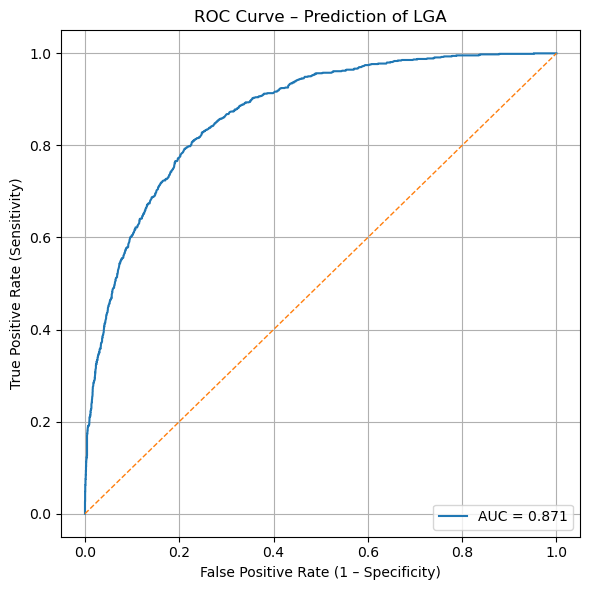

In [59]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
y_scr  = merged["predicted_bw_brenner"].values
fpr, tpr, thresholds = roc_curve(y_true, y_scr)
auc = roc_auc_score(y_true, y_scr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], "--", linewidth=1)
plt.xlabel("False Positive Rate (1 – Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("ROC Curve – Prediction of LGA")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

## Characteristic 

In [60]:
tp = merged[(merged["LGA_predicted"] == 1) & (merged["LGA_actual"] == 1)]
fp = merged[(merged["LGA_predicted"] == 1) & (merged["LGA_actual"] == 0)]
fn = merged[(merged["LGA_predicted"] == 0) & (merged["LGA_actual"] == 1)]
tn = merged[(merged["LGA_predicted"] == 0) & (merged["LGA_actual"] == 0)]

In [61]:
total_n_tp = len(tp)                           # new N for Table 1 header
print(f"TP(N) = {total_n_tp:,}")

TP(N) = 712


In [62]:
var = tp["mom_age"]                 # ← just change this
miss_n   = var.isna().sum()
miss_pct = miss_n / total_n_tp * 100

print(f"Mean (SD):         {var.mean():.1f} ({var.std(ddof=1):.2f})")
print(f"Median [Min, Max]: {var.median():.1f} [{var.min():.1f}, {var.max():.1f}]")
print(f"Missing (n, %):      {miss_n} ({miss_pct:.1f}%)")

Mean (SD):         31.6 (4.89)
Median [Min, Max]: 32.0 [18.0, 45.0]
Missing (n, %):      0 (0.0%)


In [63]:
# --------------------------------------------------
# 2)  Define the grouped race categories
race_groups = {
    "American Indian or Alaska Native": ["mom_aina"],
    "Asian":  [
        "mom_si", "mom_chi", "mom_fil",
        "mom_jap", "mom_kor", "mom_vie", "mom_oas"
    ],
    "Black":  ["mom_bla"],
    "Pacific Islander/Native Hawaiian": [
        "mom_nha", "mom_gua", "mom_sam", "mom_opi"
    ],
    "Other":  ["mom_oth"],
    "White":  ["mom_whi"],
}

# --------------------------------------------------
# 3)  Calculate counts & percentages
rows = []
for category, cols in race_groups.items():
    # any() is TRUE if the mother is flagged “1:Yes” in ANY of the columns in that group
    mask = tp[cols].eq("1:Yes").any(axis=1)
    count = int(mask.sum())
    pct   = round(100 * count / total_n_tp, 1)
    rows.append({"Race Category": category,
                 "Count (Percent)": f"{count:,} ({pct}%)"})

race_table = pd.DataFrame(rows)
print(race_table.to_string(index=False))

                   Race Category Count (Percent)
American Indian or Alaska Native        5 (0.7%)
                           Asian       33 (4.6%)
                           Black     110 (15.4%)
Pacific Islander/Native Hawaiian        2 (0.3%)
                           Other       37 (5.2%)
                           White     546 (76.7%)


In [64]:
summary = (
    tp['mhis_no'].value_counts(dropna=False)     
        .rename_axis('Category')
        .reset_index(name='n')
        .assign(pct=lambda d: (d['n'] / len(tp) * 100).round(1))
)

print(summary)

       Category    n   pct
0  Not Hispanic  658  92.4
1      Hispanic   54   7.6


In [65]:
summary = (
    tp['mom_educ'].value_counts(dropna=False)     
        .rename_axis('Category')
        .reset_index(name='n')
        .assign(pct=lambda d: (d['n'] / len(tp) * 100).round(1))
)

print(summary)

                           Category    n   pct
0               6:Bachelor's degree  175  24.6
1                 7:Master's degree  138  19.4
2         3:High School Grad or GED  118  16.6
3  4:Some college credit, no degree  112  15.7
4                5:Associate degree   85  11.9
5              8:Doctorate's degree   43   6.0
6      2:9th-12th grade, no diploma   28   3.9
7                         9:Unknown    7   1.0
8               1:8th Grade or less    6   0.8


In [66]:
summary = (
    tp['mom_employ'].value_counts(dropna=False)     
        .rename_axis('Category')
        .reset_index(name='n')
        .assign(pct=lambda d: (d['n'] / len(tp) * 100).round(1))
)

print(summary)

  Category    n   pct
0    1:Yes  514  72.2
1     0:No  198  27.8


In [67]:
var = tp["tot_preg"]                 # ← just change this

miss_n   = var.isna().sum()
miss_pct = miss_n / total_n_tp * 100

print(f"Mean (SD):         {var.mean():.1f} ({var.std(ddof=1):.2f})")
print(f"Median [Min, Max]: {var.median():.1f} [{var.min():.1f}, {var.max():.1f}]")
print(f"Missing (n, %):      {miss_n} ({miss_pct:.1f}%)")

Mean (SD):         1.9 (1.87)
Median [Min, Max]: 1.0 [0.0, 15.0]
Missing (n, %):      2 (0.3%)


In [68]:
var = tp["live_livex"]                 # ← just change this

miss_n   = var.isna().sum()
miss_pct = miss_n / total_n_tp * 100

print(f"Mean (SD):         {var.mean():.1f} ({var.std(ddof=1):.2f})")
print(f"Median [Min, Max]: {var.median():.1f} [{var.min():.1f}, {var.max():.1f}]")
print(f"Missing (n, %):      {miss_n} ({miss_pct:.1f}%)")

Mean (SD):         1.2 (1.29)
Median [Min, Max]: 1.0 [0.0, 11.0]
Missing (n, %):      3 (0.4%)


In [69]:
summary = (
    tp['sex_of_inf'].value_counts(dropna=False)     
        .rename_axis('Category')
        .reset_index(name='n')
        .assign(pct=lambda d: (d['n'] / len(tp) * 100).round(2))
)

print(summary)

   Category    n    pct
0    1:Male  457  64.19
1  2:Female  255  35.81


In [70]:
#### # --------------------------------------------------
# 1)  Boolean flags (new column name : original raw column)
risk_map = {
    "abruptio_placenta"    : "abrupt",
    "diabetes_gestational" : "diabetes_g",
    "diabetes_prepreg"     : "diabetes_m",
    "hypertension_prepreg" : "hyper_chro",
    "hypertension_preg"    : "hyper_preg",
    "eclampsia"            : "eclampsiax",
    "infertility_treat"    : "inferti",
    "infert_med_flag"      : "infert_med",
    "infert_art_flag"      : "infert_art",
    "other_chronic"        : "other_ill",
    "poor_outcome"         : "poor_preg",
    "prelab_referral"      : "prelab_ref",
    "preterm_prev"         : "pre_term_m",
    "previous_cs"          : "prev_cs",
    "unknown_risk"         : "unk_risk",
    "vaginal_bleeding"     : "vag_"
}

for new, raw in risk_map.items():
    tp[new] = tp[raw].eq("1:Yes")

# --------------------------------------------------
# 2)  Pretty labels for the table
label_map = {
    "abruptio_placenta"    : "Abruptio Placenta",
    "diabetes_gestational" : "Diabetes, gestational",
    "diabetes_prepreg"     : "Diabetes, pre-pregnancy",
    "hypertension_prepreg" : "Hypertension, pre-pregnancy",
    "hypertension_preg"    : "Hypertension, pregnancy-related",
    "eclampsia"            : "Eclampsia",
    "infertility_treat"    : "Infertility Treatments",
    "infert_med_flag"      : "Infertility/Fertility Enhancing Drugs",
    "infert_art_flag"      : "Infertility/Assisted Reproductive Technology",
    "other_chronic"        : "Other Serious Chronic Diseases",
    "poor_outcome"         : "Poor pregnancy outcomes",
    "prelab_referral"      : "Pre-labor Referral for High Risk",
    "preterm_prev"         : "Pre-term infant, previous",
    "previous_cs"          : "Previous Cesarean Section",
    "unknown_risk"         : "Unknown",
    "vaginal_bleeding"     : "Vaginal bleeding"
}

# --------------------------------------------------
# 3)  Summarise (multiple responses allowed)
rows = []
for col in risk_map.keys():
    n   = int(tp[col].sum())
    pct = round(n / total_n_tp * 100, 1)
    rows.append({
        "Pregnancy Risk Factor": label_map[col],
        "Count (Percent)"      : f"{n} ({pct}%)"
    })

risk_table = pd.DataFrame(rows).sort_values("Count (Percent)")
print(risk_table.to_string(index=False))


                       Pregnancy Risk Factor Count (Percent)
                                   Eclampsia        0 (0.0%)
            Pre-labor Referral for High Risk     102 (14.3%)
                       Diabetes, gestational     129 (18.1%)
             Hypertension, pregnancy-related     140 (19.7%)
                   Previous Cesarean Section     195 (27.4%)
       Infertility/Fertility Enhancing Drugs       20 (2.8%)
Infertility/Assisted Reproductive Technology       26 (3.7%)
                           Abruptio Placenta        3 (0.4%)
                     Poor pregnancy outcomes       32 (4.5%)
                                     Unknown        4 (0.6%)
                      Infertility Treatments       41 (5.8%)
                   Pre-term infant, previous       43 (6.0%)
                     Diabetes, pre-pregnancy       45 (6.3%)
              Other Serious Chronic Diseases       49 (6.9%)
                            Vaginal bleeding      85 (11.9%)
                 Hyperte

/var/folders/nw/3jwfxsxs5hjf1kw6d5bq2bnw0000gn/T/ipykernel_15655/1230779845.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tp[new] = tp[raw].eq("1:Yes")
/var/folders/nw/3jwfxsxs5hjf1kw6d5bq2bnw0000gn/T/ipykernel_15655/1230779845.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tp[new] = tp[raw].eq("1:Yes")
/var/folders/nw/3jwfxsxs5hjf1kw6d5bq2bnw0000gn/T/ipykernel_15655/1230779845.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [71]:
summary = (
    tp['none_congm'].value_counts(dropna=False)     
        .rename_axis('Category')
        .reset_index(name='n')
        .assign(pct=lambda d: (d['n'] / len(tp) * 100).round(1))
)

print(summary)

                           Category    n   pct
0  1:No Congenitial anomaly present  688  96.6
1     0:Congenitial anomaly present   24   3.4


In [72]:
total_n_tn = len(tn)                           # new N for Table 1 header
print(f"TN(N) = {total_n_tn:,}")

TN(N) = 3,197


In [73]:
var = tn["mom_age"]                 # ← just change this
miss_n   = var.isna().sum()
miss_pct = miss_n / total_n_tn * 100

print(f"Mean (SD):         {var.mean():.1f} ({var.std(ddof=1):.2f})")
print(f"Median [Min, Max]: {var.median():.1f} [{var.min():.1f}, {var.max():.1f}]")
print(f"Missing (n, %):      {miss_n} ({miss_pct:.1f}%)")

Mean (SD):         30.0 (5.40)
Median [Min, Max]: 30.0 [15.0, 52.0]
Missing (n, %):      0 (0.0%)


In [74]:
# --------------------------------------------------
# 2)  Define the grouped race categories
race_groups = {
    "American Indian or Alaska Native": ["mom_aina"],
    "Asian":  [
        "mom_si", "mom_chi", "mom_fil",
        "mom_jap", "mom_kor", "mom_vie", "mom_oas"
    ],
    "Black":  ["mom_bla"],
    "Pacific Islander/Native Hawaiian": [
        "mom_nha", "mom_gua", "mom_sam", "mom_opi"
    ],
    "Other":  ["mom_oth"],
    "White":  ["mom_whi"],
}

# --------------------------------------------------
# 3)  Calculate counts & percentages
rows = []
for category, cols in race_groups.items():
    # any() is TRUE if the mother is flagged “1:Yes” in ANY of the columns in that group
    mask = tn[cols].eq("1:Yes").any(axis=1)
    count = int(mask.sum())
    pct   = round(100 * count / total_n_tn, 1)
    rows.append({"Race Category": category,
                 "Count (Percent)": f"{count:,} ({pct}%)"})

race_table = pd.DataFrame(rows)
print(race_table.to_string(index=False))

                   Race Category Count (Percent)
American Indian or Alaska Native       26 (0.8%)
                           Asian      181 (5.7%)
                           Black     807 (25.2%)
Pacific Islander/Native Hawaiian        3 (0.1%)
                           Other      135 (4.2%)
                           White   2,146 (67.1%)


In [75]:
summary = (
    tn['mhis_no'].value_counts(dropna=False)     
        .rename_axis('Category')
        .reset_index(name='n')
        .assign(pct=lambda d: (d['n'] / len(tn) * 100).round(1))
)

print(summary)

       Category     n   pct
0  Not Hispanic  2929  91.6
1      Hispanic   268   8.4


In [76]:
summary = (
    tn['mom_educ'].value_counts(dropna=False)     
        .rename_axis('Category')
        .reset_index(name='n')
        .assign(pct=lambda d: (d['n'] / len(tn) * 100).round(1))
)

print(summary)

                           Category    n   pct
0               6:Bachelor's degree  721  22.6
1         3:High School Grad or GED  682  21.3
2                 7:Master's degree  531  16.6
3  4:Some college credit, no degree  468  14.6
4                5:Associate degree  332  10.4
5      2:9th-12th grade, no diploma  232   7.3
6              8:Doctorate's degree  165   5.2
7                         9:Unknown   39   1.2
8               1:8th Grade or less   27   0.8


In [77]:
summary = (
    tn['mom_employ'].value_counts(dropna=False)     
        .rename_axis('Category')
        .reset_index(name='n')
        .assign(pct=lambda d: (d['n'] / len(tn) * 100).round(1))
)

print(summary)

  Category     n   pct
0    1:Yes  2212  69.2
1     0:No   985  30.8


In [78]:
var = tn["tot_preg"]                 # ← just change this

miss_n   = var.isna().sum()
miss_pct = miss_n / total_n_tn * 100

print(f"Mean (SD):         {var.mean():.1f} ({var.std(ddof=1):.2f})")
print(f"Median [Min, Max]: {var.median():.1f} [{var.min():.1f}, {var.max():.1f}]")
print(f"Missing (n, %):      {miss_n} ({miss_pct:.1f}%)")

Mean (SD):         1.8 (1.99)
Median [Min, Max]: 1.0 [0.0, 15.0]
Missing (n, %):      12 (0.4%)


In [79]:
var = tn["live_livex"]                 # ← just change this

miss_n   = var.isna().sum()
miss_pct = miss_n / total_n_tn * 100

print(f"Mean (SD):         {var.mean():.1f} ({var.std(ddof=1):.2f})")
print(f"Median [Min, Max]: {var.median():.1f} [{var.min():.1f}, {var.max():.1f}]")
print(f"Missing (n, %):      {miss_n} ({miss_pct:.1f}%)")

Mean (SD):         1.0 (1.19)
Median [Min, Max]: 1.0 [0.0, 10.0]
Missing (n, %):      13 (0.4%)


In [80]:
summary = (
    tn['sex_of_inf'].value_counts(dropna=False)     
        .rename_axis('Category')
        .reset_index(name='n')
        .assign(pct=lambda d: (d['n'] / len(tn) * 100).round(2))
)

print(summary)

   Category     n    pct
0  2:Female  1715  53.64
1    1:Male  1482  46.36


In [81]:
#### # --------------------------------------------------
# 1)  Boolean flags (new column name : original raw column)
risk_map = {
    "abruptio_placenta"    : "abrupt",
    "diabetes_gestational" : "diabetes_g",
    "diabetes_prepreg"     : "diabetes_m",
    "hypertension_prepreg" : "hyper_chro",
    "hypertension_preg"    : "hyper_preg",
    "eclampsia"            : "eclampsiax",
    "infertility_treat"    : "inferti",
    "infert_med_flag"      : "infert_med",
    "infert_art_flag"      : "infert_art",
    "other_chronic"        : "other_ill",
    "poor_outcome"         : "poor_preg",
    "prelab_referral"      : "prelab_ref",
    "preterm_prev"         : "pre_term_m",
    "previous_cs"          : "prev_cs",
    "unknown_risk"         : "unk_risk",
    "vaginal_bleeding"     : "vag_"
}

for new, raw in risk_map.items():
    tn[new] = tn[raw].eq("1:Yes")

# --------------------------------------------------
# 2)  Pretty labels for the table
label_map = {
    "abruptio_placenta"    : "Abruptio Placenta",
    "diabetes_gestational" : "Diabetes, gestational",
    "diabetes_prepreg"     : "Diabetes, pre-pregnancy",
    "hypertension_prepreg" : "Hypertension, pre-pregnancy",
    "hypertension_preg"    : "Hypertension, pregnancy-related",
    "eclampsia"            : "Eclampsia",
    "infertility_treat"    : "Infertility Treatments",
    "infert_med_flag"      : "Infertility/Fertility Enhancing Drugs",
    "infert_art_flag"      : "Infertility/Assisted Reproductive Technology",
    "other_chronic"        : "Other Serious Chronic Diseases",
    "poor_outcome"         : "Poor pregnancy outcomes",
    "prelab_referral"      : "Pre-labor Referral for High Risk",
    "preterm_prev"         : "Pre-term infant, previous",
    "previous_cs"          : "Previous Cesarean Section",
    "unknown_risk"         : "Unknown",
    "vaginal_bleeding"     : "Vaginal bleeding"
}

# --------------------------------------------------
# 3)  Summarise (multiple responses allowed)
rows = []
for col in risk_map.keys():
    n   = int(tn[col].sum())
    pct = round(n / total_n_tn * 100, 1)
    rows.append({
        "Pregnancy Risk Factor": label_map[col],
        "Count (Percent)"      : f"{n} ({pct}%)"
    })

risk_table = pd.DataFrame(rows).sort_values("Count (Percent)")
print(risk_table.to_string(index=False))

                       Pregnancy Risk Factor Count (Percent)
                                   Eclampsia        0 (0.0%)
       Infertility/Fertility Enhancing Drugs      101 (3.2%)
                      Infertility Treatments      159 (5.0%)
                     Poor pregnancy outcomes      171 (5.3%)
                   Pre-term infant, previous      184 (5.8%)
                                     Unknown       19 (0.6%)
                       Diabetes, gestational      266 (8.3%)
              Other Serious Chronic Diseases      285 (8.9%)
                 Hypertension, pre-pregnancy     365 (11.4%)
                           Abruptio Placenta       43 (1.3%)
            Pre-labor Referral for High Risk     432 (13.5%)
                            Vaginal bleeding     441 (13.8%)
                   Previous Cesarean Section     459 (14.4%)
             Hypertension, pregnancy-related     564 (17.6%)
                     Diabetes, pre-pregnancy       69 (2.2%)
Infertility/Assisted Rep

/var/folders/nw/3jwfxsxs5hjf1kw6d5bq2bnw0000gn/T/ipykernel_15655/4239333415.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tn[new] = tn[raw].eq("1:Yes")
/var/folders/nw/3jwfxsxs5hjf1kw6d5bq2bnw0000gn/T/ipykernel_15655/4239333415.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tn[new] = tn[raw].eq("1:Yes")
/var/folders/nw/3jwfxsxs5hjf1kw6d5bq2bnw0000gn/T/ipykernel_15655/4239333415.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [82]:
summary = (
    tn['none_congm'].value_counts(dropna=False)     
        .rename_axis('Category')
        .reset_index(name='n')
        .assign(pct=lambda d: (d['n'] / len(tn) * 100).round(1))
)

print(summary)

                           Category     n   pct
0  1:No Congenitial anomaly present  3099  96.9
1     0:Congenitial anomaly present    98   3.1


In [83]:
# ---------------------------------------------------------------------------
# 1)  Build the groups dictionary ─ now with an “Overall” cohort
# ---------------------------------------------------------------------------
groups = {"TN": tn, "TP": tp, "FN": fn, "FP": fp}
groups["Overall"] = pd.concat(groups.values(), ignore_index=True)

# ---------------------------------------------------------------------------
# 2)  Config: variables & mappings  (edit only if you want to add/remove)
# ---------------------------------------------------------------------------
# ---- continuous variables ---------------------------------------------------
cont_vars = [
    "mom_age",           # maternal age (yrs)
    "tot_preg",          # total previous pregnancies
    "live_livex",        # live births now living
    "deliv_days",        # NEW: gestational age at delivery (days)
    "birth_wgt",         # NEW: birth weight (g)
]

# ---- categorical variables --------------------------------------------------
cat_vars = ["mhis_no", "mom_educ", "mom_employ",
            "sex_of_inf", "none_congm"]

# ---- mutually-exclusive race categories built from multiple 0/1 flags -------
race_groups = {
    "American Indian or Alaska Native": ["mom_aina"],
    "Asian": [
        "mom_si", "mom_chi", "mom_fil",
        "mom_jap", "mom_kor", "mom_vie", "mom_oas"
    ],
    "Black":  ["mom_bla"],
    "Pacific Islander/Native Hawaiian": ["mom_nha", "mom_gua",
                                         "mom_sam", "mom_opi"],
    "Other":  ["mom_oth"],
    "White":  ["mom_whi"],
}

# ---- pregnancy-risk factor flags -------------------------------------------
risk_map = {
    "abruptio_placenta"    : "abrupt",
    "diabetes_gestational" : "diabetes_g",
    "diabetes_prepreg"     : "diabetes_m",
    "hypertension_prepreg" : "hyper_chro",
    "hypertension_preg"    : "hyper_preg",
    "eclampsia"            : "eclampsiax",
    "infertility_treat"    : "inferti",
    "infert_med_flag"      : "infert_med",
    "infert_art_flag"      : "infert_art",
    "other_chronic"        : "other_ill",
    "poor_outcome"         : "poor_preg",
    "prelab_referral"      : "prelab_ref",
    "preterm_prev"         : "pre_term_m",
    "previous_cs"          : "prev_cs",
    "unknown_risk"         : "unk_risk",
    "vaginal_bleeding"     : "vag_",
}

# Pretty labels for risk-factor table
label_map = {
    "abruptio_placenta"    : "Abruptio Placenta",
    "diabetes_gestational" : "Diabetes, gestational",
    "diabetes_prepreg"     : "Diabetes, pre-pregnancy",
    "hypertension_prepreg" : "Hypertension, pre-pregnancy",
    "hypertension_preg"    : "Hypertension, pregnancy-related",
    "eclampsia"            : "Eclampsia",
    "infertility_treat"    : "Infertility treatments",
    "infert_med_flag"      : "Infertility/Fertility drugs",
    "infert_art_flag"      : "Infertility/Assisted reproductive tech",
    "other_chronic"        : "Other chronic diseases",
    "poor_outcome"         : "Poor pregnancy outcomes",
    "prelab_referral"      : "Pre-labour referral (high-risk)",
    "preterm_prev"         : "Pre-term infant, previous",
    "previous_cs"          : "Previous Caesarean section",
    "unknown_risk"         : "Unknown risk",
    "vaginal_bleeding"     : "Vaginal bleeding",
}

# ---------------------------------------------------------------------------
# 3)  Helper functions
# ---------------------------------------------------------------------------
def summarize_continuous(df: pd.DataFrame, vars_list):
    """Return per-variable summary for continuous variables."""
    rows = []
    n_total = len(df)
    for v in vars_list:
        s = df[v]
        rows.append({
            "variable": v,
            "n":           s.notna().sum(),
            "mean":        s.mean(),
            "sd":          s.std(ddof=1),
            "median":      s.median(),
            "p25":         s.quantile(0.25),
            "p75":         s.quantile(0.75),
            "min":         s.min(),
            "max":         s.max(),
            "missing_n":   s.isna().sum(),
            "missing_pct": round(s.isna().sum() / n_total * 100, 1),
        })
    return pd.DataFrame(rows).set_index("variable")

def summarize_race(df: pd.DataFrame, race_groups):
    total_n = len(df)
    rows = []
    for category, cols in race_groups.items():
        mask   = df[cols].eq("1:Yes").any(axis=1)
        count  = int(mask.sum())
        rows.append({
            "Race Category": category,
            "Count":        count,
            "Percent":      round(100 * count / total_n, 1),
        })
    return pd.DataFrame(rows)

def summarize_categorical(df: pd.DataFrame, var):
    tab = (df[var]
           .value_counts(dropna=False)
           .rename_axis("Category")
           .reset_index(name="n"))
    tab["pct"] = (tab["n"] / len(df) * 100).round(1)
    return tab

def summarize_risk_factors(df: pd.DataFrame, risk_map, label_map):
    n_total = len(df)
    tmp = df.copy()
    # create boolean columns on-the-fly
    for new, raw in risk_map.items():
        tmp[new] = tmp[raw].eq("1:Yes")
    rows = []
    for new in risk_map.keys():
        n   = int(tmp[new].sum())
        pct = round(n / n_total * 100, 1)
        rows.append({
            "Pregnancy Risk Factor": label_map[new],
            "Count":                n,
            "Percent":              pct,
        })
    return pd.DataFrame(rows).sort_values("Percent", ascending=False)

# ---------------------------------------------------------------------------
# 4)  Run summaries for every cohort (TN, TP, FN, FP, Overall)
# ---------------------------------------------------------------------------
all_outputs = {}

for gname, gdf in groups.items():
    print("\n" + "=" * 80)
    print(f"{gname}  (N = {len(gdf):,})")
    print("=" * 80)

    # ---- continuous variables ----------------------------------------------
    cont_tbl = summarize_continuous(gdf, cont_vars).round(2)

    # ---- race ---------------------------------------------------------------
    race_tbl = summarize_race(gdf, race_groups)

    # ---- categorical variables ---------------------------------------------
    cat_tbls = {v: summarize_categorical(gdf, v) for v in cat_vars}

    # ---- pregnancy risk factors --------------------------------------------
    risk_tbl = summarize_risk_factors(gdf, risk_map, label_map)

    # ---- store everything ---------------------------------------------------
    all_outputs[gname] = {
        "continuous":  cont_tbl,
        "race":        race_tbl,
        "categorical": cat_tbls,
        "risk":        risk_tbl,
    }

    # ---- quick console preview ---------------------------------------------
    print("\n-- Continuous variables --")
    print(cont_tbl)

    print("\n-- Race (collapsed) --")
    print(race_tbl.to_string(index=False))

    print("\n-- Categorical variables --")
    for v, t in cat_tbls.items():
        print(f"\n{v}")
        print(t.to_string(index=False))

    print("\n-- Pregnancy risk factors --")
    print(risk_tbl.to_string(index=False))


TN  (N = 3,197)

-- Continuous variables --
               n     mean      sd  median     p25     p75     min     max  \
variable                                                                    
mom_age     3197    30.04    5.40    30.0    26.0    34.0    15.0    52.0   
tot_preg    3185     1.78    1.99     1.0     0.0     3.0     0.0    15.0   
live_livex  3184     0.97    1.19     1.0     0.0     1.0     0.0    10.0   
deliv_days  3197   277.38    8.62   277.0   272.0   284.0   253.0   294.0   
birth_wgt   3197  3159.27  407.61  3200.0  2892.0  3455.0  1590.0  4080.0   

            missing_n  missing_pct  
variable                            
mom_age             0          0.0  
tot_preg           12          0.4  
live_livex         13          0.4  
deliv_days          0          0.0  
birth_wgt           0          0.0  

-- Race (collapsed) --
                   Race Category  Count  Percent
American Indian or Alaska Native     26      0.8
                           Asian  


-- Continuous variables --
               n     mean      sd  median      p25     p75     min     max  \
variable                                                                     
mom_age     4568    30.47    5.29    31.0    27.00    34.0    15.0    52.0   
tot_preg    4552     1.82    1.97     1.0     0.00     3.0     0.0    15.0   
live_livex  4550     1.03    1.22     1.0     0.00     2.0     0.0    11.0   
deliv_days  4568   276.81    8.72   276.0   272.00   284.0   252.0   294.0   
birth_wgt   4568  3370.56  515.66  3370.0  3024.75  3710.0  1590.0  5200.0   

            missing_n  missing_pct  
variable                            
mom_age             0          0.0  
tot_preg           16          0.4  
live_livex         18          0.4  
deliv_days          0          0.0  
birth_wgt           0          0.0  

-- Race (collapsed) --
                   Race Category  Count  Percent
American Indian or Alaska Native     34      0.7
                           Asian    238     

In [84]:
# =============================================================================
#  P-VALUES FOR TN vs FP  ── continuous, categorical, race, risk-factor blocks
# =============================================================================
import numpy as np
import pandas as pd
from scipy import stats

# ------------------------------------------------------------------
# 0.  Shortcuts for the two comparison groups
# ------------------------------------------------------------------
tn_df = groups["TN"]
fp_df = groups["FP"]

# ------------------------------------------------------------------
# 1.  Continuous variables  → Welch’s t-test
# ------------------------------------------------------------------
cont_pvals = []
for v in cont_vars:
    t_stat, p_val = stats.ttest_ind(tn_df[v], fp_df[v], equal_var=False)
    cont_pvals.append(
        {"Variable": v,
         "TN_mean": tn_df[v].mean(),
         "FP_mean": fp_df[v].mean(),
         "P_value": p_val}
    )
cont_pvals = pd.DataFrame(cont_pvals)

# ------------------------------------------------------------------
# 2.  Standard categorical variables  → χ² (or Fisher if 2×2 with small exp.)
# ------------------------------------------------------------------
cat_pvals = []
for v in cat_vars:
    levels = pd.concat([tn_df[v], fp_df[v]]).unique()
    tn_counts = tn_df[v].value_counts().reindex(levels, fill_value=0)
    fp_counts = fp_df[v].value_counts().reindex(levels, fill_value=0)
    table = np.vstack([tn_counts, fp_counts])        # shape 2 × K

    if table.shape[1] == 2:                          # binary variable
        exp = stats.contingency.expected_freq(table)
        if (exp < 5).any():
            p = stats.fisher_exact(table)[1]
        else:
            _, p, _, _ = stats.chi2_contingency(table)
    else:                                            # multi-level χ²
        _, p, _, _ = stats.chi2_contingency(table)

    cat_pvals.append({"Variable": v, "P_value": p})
cat_pvals = pd.DataFrame(cat_pvals)

# ------------------------------------------------------------------
# 3.  Race block (collapsed)  → global χ² across 6 categories
# ------------------------------------------------------------------
# ------------------------------------------------------------------
# 3.  Race block (collapsed)  → global χ² or Fisher exact
# ------------------------------------------------------------------
def collapse_race(df):
    """Return a Series with one mutually exclusive race label per row."""
    cols_bool = []
    for lbl, flag_cols in race_groups.items():
        cols_bool.append(df[flag_cols].eq("1:Yes").any(axis=1).rename(lbl))
    return pd.concat(cols_bool, axis=1).idxmax(axis=1)

tn_race = collapse_race(tn_df)
fp_race = collapse_race(fp_df)

# 2 × K table: first row = TN counts, second row = FP counts
levels = list(race_groups.keys())                      # preserve order
tn_counts = tn_race.value_counts().reindex(levels, fill_value=0)
fp_counts = fp_race.value_counts().reindex(levels, fill_value=0)
race_table = np.vstack([tn_counts, fp_counts])

# Drop race categories absent in both groups
keep_cols = race_table.sum(axis=0) > 0
race_table = race_table[:, keep_cols]

# Choose appropriate test
if race_table.shape[1] == 2:                           # 2×2 after pruning
    exp = stats.contingency.expected_freq(race_table)
    if (exp < 5).any():
        race_p = stats.fisher_exact(race_table)[1]
    else:
        _, race_p, _, _ = stats.chi2_contingency(race_table)
else:                                                  # ≥3 levels
    _, race_p, _, _ = stats.chi2_contingency(race_table)

race_pval = pd.DataFrame(
    [{"Variable": "Race (collapsed)", "P_value": race_p}]
)
# ------------------------------------------------------------------
# 4.  Pregnancy risk-factor block  → global χ² across all binary flags
# ------------------------------------------------------------------
# ------------------------------------------------------------------
# 4.  Pregnancy risk-factor block  → global χ² across all binary flags
# ------------------------------------------------------------------
tn_flags = tn_df[list(risk_map.values())].eq("1:Yes")
tn_flags.columns = list(risk_map.keys())

fp_flags = fp_df[list(risk_map.values())].eq("1:Yes")
fp_flags.columns = list(risk_map.keys())

# Build k × 2 table: each row = risk factor, cols = TN vs FP counts
risk_counts = pd.DataFrame({
    "TN": tn_flags.sum(),
    "FP": fp_flags.sum()
})

# Drop rows with zero total (no events in either group)
risk_counts = risk_counts[risk_counts.sum(axis=1) > 0]

# If at least two non-empty rows remain, run χ²; otherwise set p = NaN
if risk_counts.shape[0] >= 2:
    _, risk_p, _, _ = stats.chi2_contingency(risk_counts)
else:
    risk_p = np.nan

risk_pval = pd.DataFrame([{
    "Variable": "Pregnancy risk factors (overall)",
    "P_value": risk_p
}])
# ------------------------------------------------------------------
# 5.  Combine results and display
# ------------------------------------------------------------------
pval_table = (pd.concat([cont_pvals, cat_pvals, race_pval, risk_pval],
                        ignore_index=True)
                .sort_values("P_value"))

print("\nP-values for TN vs FP comparison")
print(pval_table.to_string(index=False, float_format="%.4g"))



P-values for TN vs FP comparison
                        Variable  TN_mean  FP_mean    P_value
                       birth_wgt     3159     3543 7.002e-111
                         mom_age    30.04    31.59  4.165e-10
                      mom_employ      NaN      NaN  0.0004981
Pregnancy risk factors (overall)      NaN      NaN   0.001438
                        mom_educ      NaN      NaN   0.002729
                Race (collapsed)      NaN      NaN   0.005064
                      sex_of_inf      NaN      NaN     0.1414
                      deliv_days    277.4    276.8     0.2113
                      none_congm      NaN      NaN     0.3321
                         mhis_no      NaN      NaN     0.7435
                        tot_preg    1.781    1.844        NaN
                      live_livex   0.9686    1.084        NaN


## Perterm and term baby comparsion

In [85]:
preterm = merged[merged["deliv_days"]<259]
preterm

,MRN,Date___Time,hospcode,reszip5,sex_of_inf,plurality,birth_orde,birth_wgt,mom_medrec,mom_whi,...,predicted_bw_brenner,error_brenner,abs_error_brenner,pct_error_brenner,abs_pct_error_brenner,log_AWE,wt_p90_a,LGA_actual,LGA_predicted,LGA_false_pos
46,1060346,2016-05-19,Strong,14534.0,2:Female,1:Single,single,4215,1060346,1:Yes,...,3763,-452,452,-10.723606,10.723606,6.115892,3320.0,1,1,0
62,1103910,2014-09-02,Strong,14619.0,1:Male,1:Single,single,2415,1103910,1:Yes,...,2231,-184,184,-7.619048,7.619048,5.220356,3320.0,0,0,0
201,1284136,2017-04-24,Strong,14611.0,1:Male,1:Single,single,4940,1284136,0:No,...,4549,-391,391,-7.91498,7.91498,5.971262,3320.0,1,1,0
368,732938,2017-01-05,Highland,14620.0,1:Male,1:Single,single,2830,732938,0:No,...,3130,300,300,10.600707,10.600707,5.70711,3320.0,0,0,0
395,E1008393,2020-08-25,Strong,14609.0,2:Female,1:Single,single,2790,E1008393,0:No,...,2551,-239,239,-8.566308,8.566308,5.480639,3320.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5888,E922418,2019-08-06,Strong,14619.0,2:Female,1:Single,single,1990,E922418,0:No,...,1900,-90,90,-4.522613,4.522613,4.51086,3320.0,0,0,0
5927,E934615,2018-05-30,Strong,14526.0,2:Female,1:Single,single,1865,E934615,1:Yes,...,1918,53,53,2.841823,2.841823,3.988984,3320.0,0,0,0
5939,E941176,2022-11-14,Highland,14624.0,2:Female,1:Single,single,2838,E941176,0:No,...,2576,-262,262,-9.231853,9.231853,5.572154,3320.0,0,0,0
5976,E955848,2021-06-16,Strong,14626.0,2:Female,1:Single,single,2980,E955848,1:Yes,...,2822,-158,158,-5.302013,5.302013,5.068904,3320.0,0,0,0


In [86]:
a_lga_n_preterm = preterm["LGA_actual"].sum()
a_lga_pct_preterm   = preterm["LGA_actual"].mean()*100
print(a_lga_n_preterm, f"{a_lga_pct_preterm:.2f}%")

24 26.97%


In [87]:
p_lga_n_preterm = preterm["LGA_predicted"].sum()
p_lga_pct_preterm = preterm["LGA_predicted"].mean() * 100
print(p_lga_n_preterm, f"{p_lga_pct_preterm:.2f}%")

21 23.60%


In [88]:
# % of babies predicted lga- but actually not lga-
preterm["LGA_false_pos"] = np.where(
    (preterm["LGA_predicted"] == 1) & (preterm["LGA_actual"] == 0), 1, 0
)

fp_n_preterm   = preterm["LGA_false_pos"].sum()
fp_pct_preterm = fp_n_preterm / len(preterm) * 100          # percent of *all* babies
print(fp_n_preterm, f"{fp_pct_preterm:.2f}%")

6 6.74%


/var/folders/nw/3jwfxsxs5hjf1kw6d5bq2bnw0000gn/T/ipykernel_15655/2449530275.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preterm["LGA_false_pos"] = np.where(


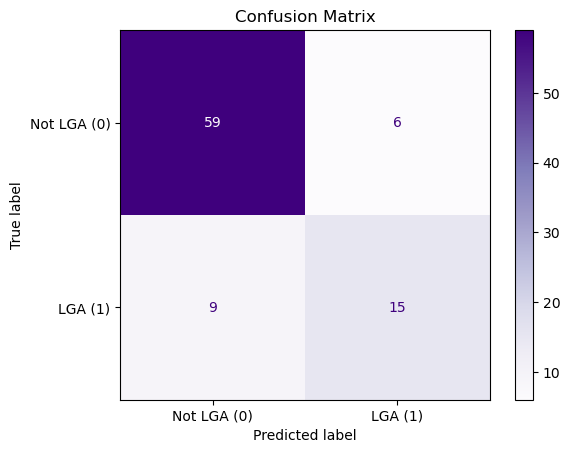

In [89]:
y_true_preterm = preterm["LGA_actual"].astype(int).values       
y_pred_preterm = preterm["LGA_predicted"].astype(int).values    
cm_preterm = confusion_matrix(y_true_preterm, y_pred_preterm)

labels = ["Not LGA (0)", "LGA (1)"]
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_preterm, display_labels=labels)
disp_train.plot(cmap='Purples')
plt.title("Confusion Matrix")
plt.show()

In [90]:
tn_preterm, fp_preterm, fn_preterm, tp_preterm = cm_preterm.ravel()
sensitivity_preterm = tp_preterm / (tp_preterm + fn_preterm)          # recall, TPR
sensitivity_preterm_ci     = wilson_ci(tp_preterm, tp_preterm + fn_preterm)

specificity_preterm = tn_preterm / (tn_preterm + fp_preterm)          # TNR
specificity_preterm_ci     = wilson_ci(tn_preterm, tn_preterm + fp_preterm)

print(f"Sensitivity: {sensitivity_preterm:.3%} {sensitivity_preterm_ci}")
print(f"Specificity: {specificity_preterm:.3%} {specificity_preterm_ci}")


fpr_preterm = fp_preterm / (fp_preterm + tn_preterm)           # False‑Positive Rate
fpr_preterm_ci     = wilson_ci(fp_preterm, fp_preterm + tn_preterm)
print(f"FPR  (1‑Specificity): {fpr_preterm:.3%} {fpr_preterm_ci}")

Sensitivity: 62.500% (0.42709619037907065, 0.7884086656636855)
Specificity: 90.769% (0.8128778304982671, 0.957005495862538)
FPR  (1‑Specificity): 9.231% (0.04299450413746197, 0.18712216950173294)


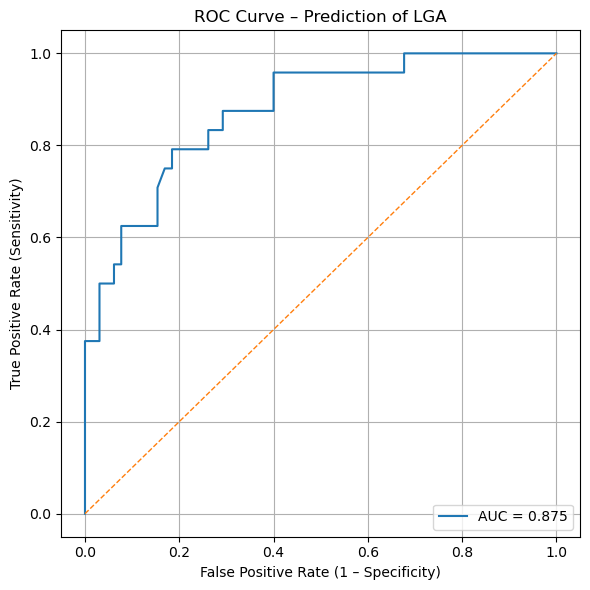

In [91]:
y_scr_preterm  = preterm["predicted_bw_brenner"].values
fpr_preterm, tpr_preterm, thresholds_preterm = roc_curve(y_true_preterm, y_scr_preterm)
auc_preterm = roc_auc_score(y_true_preterm, y_scr_preterm)

plt.figure(figsize=(6, 6))
plt.plot(fpr_preterm, tpr_preterm, label=f"AUC = {auc_preterm:.3f}")
plt.plot([0, 1], [0, 1], "--", linewidth=1)
plt.xlabel("False Positive Rate (1 – Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("ROC Curve – Prediction of LGA")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [92]:
term = merged[merged["deliv_days"]>=259]
term

,MRN,Date___Time,hospcode,reszip5,sex_of_inf,plurality,birth_orde,birth_wgt,mom_medrec,mom_whi,...,predicted_bw_brenner,error_brenner,abs_error_brenner,pct_error_brenner,abs_pct_error_brenner,log_AWE,wt_p90_a,LGA_actual,LGA_predicted,LGA_false_pos
0,006520,2015-03-03,Highland,14607.0,1:Male,1:Single,single,3754,006520,1:Yes,...,3590,-164,164,-4.368673,4.368673,5.105945,3982.0,0,0,0
1,008177,2014-01-31,Highland,14620.0,2:Female,1:Single,single,3419,008177,1:Yes,...,3253,-166,166,-4.855221,4.855221,5.117994,3918.0,0,0,0
2,018533,2014-06-03,Highland,14618.0,1:Male,1:Single,single,3538,018533,1:Yes,...,3724,186,186,5.257207,5.257207,5.231109,3451.0,1,1,0
3,020567,2015-02-26,Highland,14586.0,2:Female,1:Single,single,2929,020567,1:Yes,...,2968,39,39,1.331512,1.331512,3.688879,3940.0,0,0,0
5,028300,2015-03-26,Highland,14425.0,1:Male,1:Single,single,4278,028300,1:Yes,...,3587,-691,691,-16.152408,16.152408,6.539586,4088.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6072,E996508,2023-01-05,Strong,14450.0,1:Male,1:Single,single,3160,E996508,1:Yes,...,2902,-258,258,-8.164557,8.164557,5.556828,3982.0,0,0,0
6074,E996890,2023-05-19,Strong,14623.0,2:Female,1:Single,single,3110,E996890,0:No,...,3197,87,87,2.797428,2.797428,4.477337,3588.0,0,0,0
6075,E996991,2021-11-03,Strong,14534.0,2:Female,1:Single,single,3240,E996991,1:Yes,...,3502,262,262,8.08642,8.08642,5.572154,3451.0,0,1,1
6076,E998249,2020-04-22,Strong,14428.0,2:Female,1:Single,single,3960,E998249,1:Yes,...,3959,-1,1,-0.025253,0.025253,0.693147,3940.0,1,1,0


In [93]:
a_lga_n_term = term["LGA_actual"].sum()
a_lga_pct_term   = term["LGA_actual"].mean()*100
print(a_lga_n_term, f"{a_lga_pct_term:.2f}%")

878 19.60%


In [94]:
p_lga_n_term = term["LGA_predicted"].sum()
p_lga_pct_term = term["LGA_predicted"].mean() * 100
print(p_lga_n_term, f"{p_lga_pct_term:.2f}%")

1160 25.90%


In [95]:
# % of babies predicted lga- but actually not lga-
term["LGA_false_pos"] = np.where(
    (term["LGA_predicted"] == 1) & (term["LGA_actual"] == 0), 1, 0
)

fp_n_term   = term["LGA_false_pos"].sum()
fp_pct_term = fp_n_term / len(term) * 100          # percent of *all* babies
print(fp_n_term, f"{fp_pct_term:.2f}%")

463 10.34%


/var/folders/nw/3jwfxsxs5hjf1kw6d5bq2bnw0000gn/T/ipykernel_15655/1907585548.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  term["LGA_false_pos"] = np.where(


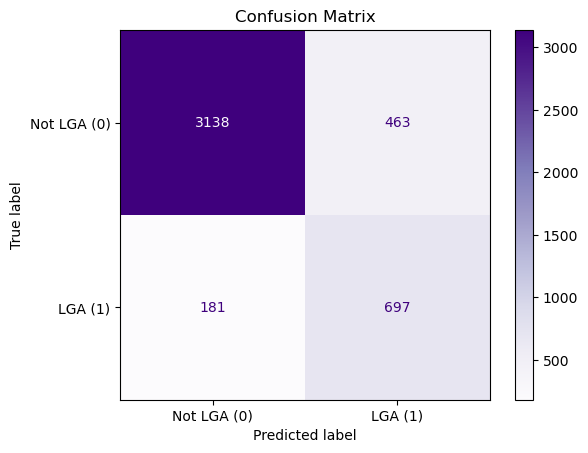

In [96]:
y_true_term = term["LGA_actual"].astype(int).values       
y_pred_term = term["LGA_predicted"].astype(int).values    
cm_term = confusion_matrix(y_true_term, y_pred_term)

labels = ["Not LGA (0)", "LGA (1)"]
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_term, display_labels=labels)
disp_train.plot(cmap='Purples')
plt.title("Confusion Matrix")
plt.show()

In [97]:
tn_term, fp_term, fn_term, tp_term = cm_term.ravel()
sensitivity_term = tp_term / (tp_term + fn_term)          # recall, TPR
sensitivity_term_ci     = wilson_ci(tp_term, tp_term + fn_term)

specificity_term = tn_term / (tn_term + fp_term)          # TNR
specificity_term_ci     = wilson_ci(tn_term, tn_term + fp_term)

print(f"Sensitivity: {sensitivity_term:.3%} {sensitivity_term_ci}")
print(f"Specificity: {specificity_term:.3%} {specificity_term_ci}")


fpr_term = fp_term / (fp_term + tn_term)           # False‑Positive Rate
fpr_term_ci     = wilson_ci(fp_term, fp_term + tn_term)
print(f"FPR  (1‑Specificity): {fpr_term:.3%} {fpr_term_ci}")

Sensitivity: 79.385% (0.7658382248620649, 0.8193008749490578)
Specificity: 87.142% (0.8600944707550757, 0.8819630998188992)
FPR  (1‑Specificity): 12.858% (0.11803690018110093, 0.1399055292449244)


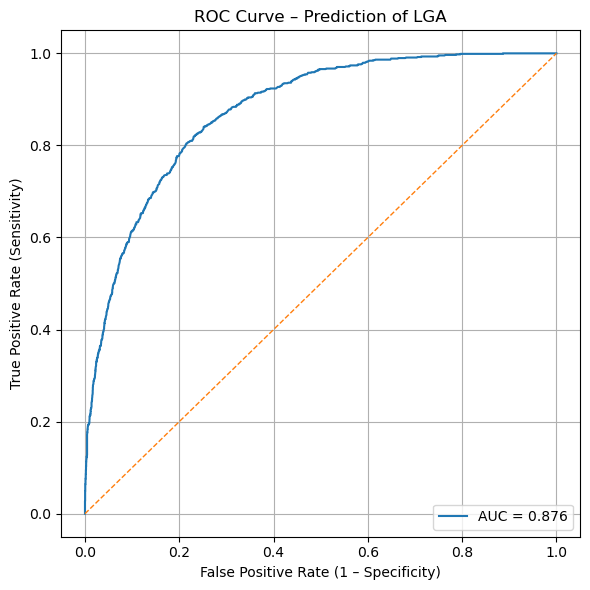

In [98]:
y_scr_term  = term["predicted_bw_brenner"].values
fpr_term, tpr_term, thresholds_term = roc_curve(y_true_term, y_scr_term)
auc_term = roc_auc_score(y_true_term, y_scr_term)

plt.figure(figsize=(6, 6))
plt.plot(fpr_term, tpr_term, label=f"AUC = {auc_term:.3f}")
plt.plot([0, 1], [0, 1], "--", linewidth=1)
plt.xlabel("False Positive Rate (1 – Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("ROC Curve – Prediction of LGA")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [99]:
from statsmodels.stats.proportion import (
    proportions_ztest,            # two‑sample z‑test
    confint_proportions_2indep    # CI for risk difference
)
from scipy.stats import fisher_exact                 # exact test (safety)

In [100]:
n_preterm_neg  = fp_preterm  + tn_preterm    # denominator for pre-term FPR
n_term_neg = fp_term + tn_term   # denominator for term FPR
count = np.array([fp_preterm, fp_term])
nobs  = np.array([n_preterm_neg, n_term_neg])
# Two-sample proportion z-test (two-sided) comparing FPRs
z_stat, p_z = proportions_ztest(count, nobs, alternative='two-sided')

# 95% CI for absolute FPR difference (term − pre-term)
# confint_proportions_2indep returns CI for p1 - p2, so pass term as 1 and pre-term as 2
ci_low, ci_upp = confint_proportions_2indep(
    count1 = fp_term, nobs1 = n_term_neg,   # term
    count2 = fp_preterm,  nobs2 = n_preterm_neg,    # pre-term
    method = "wald"
)

# 3) Fisher exact test as robustness check (on negatives only)
#     2x2 table: rows=group, cols=FP vs TN among true non-LGA
# -----------------------------------------------------------
table = np.array([[fp_preterm,  tn_preterm],
                  [fp_term, tn_term]])

oddsratio, p_fisher = fisher_exact(table, alternative='two-sided')


# -----------------------------------------------------------
# 4) Display results
# -----------------------------------------------------------
fpr_preterm  = fp_preterm  / n_preterm_neg
fpr_term = fp_term / n_term_neg
diff     = fpr_term - fpr_preterm

print(f"Pre-term FPR (FP/(FP+TN)): {fp_preterm}/{n_preterm_neg} = {fpr_preterm:.2%}")
print(f"Term     FPR (FP/(FP+TN)): {fp_term}/{n_term_neg} = {fpr_term:.2%}\n")

print(f"Two-sample z-test on FPRs:  z = {z_stat:.2f},  p = {p_z:.4f}")
print(f"Absolute FPR difference (term − pre-term): {diff:.3%}")
print(f"95% CI for (term − pre-term): {ci_low:.3%} to {ci_upp:.3%}")

print(f"\nFisher exact test on negatives only:  OR = {oddsratio:.2f},  p = {p_fisher:.4f}")


Pre-term FPR (FP/(FP+TN)): 6/65 = 9.23%
Term     FPR (FP/(FP+TN)): 463/3601 = 12.86%

Two-sample z-test on FPRs:  z = -0.87,  p = 0.3856
Absolute FPR difference (term − pre-term): 3.627%
95% CI for (term − pre-term): -3.495% to 10.748%

Fisher exact test on negatives only:  OR = 0.69,  p = 0.4583


## Male VS Female 

In [101]:
male = merged[merged["sex_of_inf"]=="1:Male"]
male

,MRN,Date___Time,hospcode,reszip5,sex_of_inf,plurality,birth_orde,birth_wgt,mom_medrec,mom_whi,...,predicted_bw_brenner,error_brenner,abs_error_brenner,pct_error_brenner,abs_pct_error_brenner,log_AWE,wt_p90_a,LGA_actual,LGA_predicted,LGA_false_pos
0,006520,2015-03-03,Highland,14607.0,1:Male,1:Single,single,3754,006520,1:Yes,...,3590,-164,164,-4.368673,4.368673,5.105945,3982.0,0,0,0
2,018533,2014-06-03,Highland,14618.0,1:Male,1:Single,single,3538,018533,1:Yes,...,3724,186,186,5.257207,5.257207,5.231109,3451.0,1,1,0
5,028300,2015-03-26,Highland,14425.0,1:Male,1:Single,single,4278,028300,1:Yes,...,3587,-691,691,-16.152408,16.152408,6.539586,4088.0,1,0,0
6,032890,2015-04-08,Highland,14612.0,1:Male,1:Single,single,3481,032890,1:Yes,...,3358,-123,123,-3.533467,3.533467,4.820282,3918.0,0,0,0
9,039281,2018-04-09,Highland,14464.0,1:Male,1:Single,single,3546,39281,1:Yes,...,3213,-333,333,-9.390863,9.390863,5.811141,3940.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6065,E994019,2022-11-16,Strong,14609.0,1:Male,1:Single,single,2770,E994019,0:No,...,2785,15,15,0.541516,0.541516,2.772589,3555.0,0,0,0
6067,E994714,2019-10-14,Strong,13165.0,1:Male,1:Single,single,3005,E994714,1:Yes,...,2979,-26,26,-0.865225,0.865225,3.295837,3487.0,0,0,0
6068,E995694,2021-11-09,Strong,14606.0,1:Male,1:Single,single,2792,E995694,0:No,...,3232,440,440,15.759312,15.759312,6.089045,4088.0,0,0,0
6071,E996012,2018-06-01,Strong,14450.0,1:Male,1:Single,single,2770,E996012,0:No,...,2623,-147,147,-5.306859,5.306859,4.997212,3682.0,0,0,0


In [102]:
a_lga_n_male = male["LGA_actual"].sum()
a_lga_pct_male   = male["LGA_actual"].mean()*100
print(a_lga_n_male, f"{a_lga_pct_male:.2f}%")

590 25.57%


In [103]:
p_lga_n_male = male["LGA_predicted"].sum()
p_lga_pct_male = male["LGA_predicted"].mean() * 100
print(p_lga_n_male, f"{p_lga_pct_male:.2f}%")

692 30.00%


In [104]:
# % of babies predicted lga- but actually not lga-
male["LGA_false_pos"] = np.where(
    (male["LGA_predicted"] == 1) & (male["LGA_actual"] == 0), 1, 0
)

fp_n_male   = male["LGA_false_pos"].sum()
fp_pct_male = fp_n_male / len(male) * 100          # percent of *all* babies
print(fp_n_male, f"{fp_pct_male:.2f}%")

235 10.19%


/var/folders/nw/3jwfxsxs5hjf1kw6d5bq2bnw0000gn/T/ipykernel_15655/1898357728.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  male["LGA_false_pos"] = np.where(


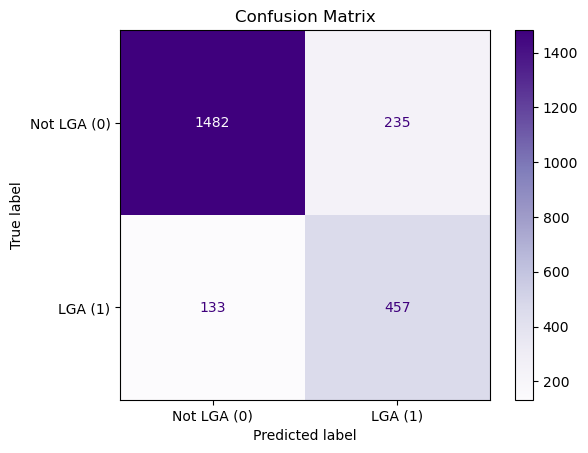

In [105]:
y_true_male = male["LGA_actual"].astype(int).values       
y_pred_male = male["LGA_predicted"].astype(int).values    
cm_male = confusion_matrix(y_true_male, y_pred_male)

labels = ["Not LGA (0)", "LGA (1)"]
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_male, display_labels=labels)
disp_train.plot(cmap='Purples')
plt.title("Confusion Matrix")
plt.show()

In [106]:
tn_male, fp_male, fn_male, tp_male = cm_male.ravel()
sensitivity_male = tp_male / (tp_male + fn_male)          # recall, TPR
sensitivity_male_ci     = wilson_ci(tp_male, tp_male + fn_male)
specificity_male = tn_male / (tn_male + fp_male)          # TNR

print(f"Sensitivity: {sensitivity_male:.3%}")
print(f"Specificity: {specificity_male:.3%}")

fpr_male = fp_male / (fp_male + tn_male)           # False‑Positive Rate
fpr_male_ci     = wilson_ci(fp_male, fp_male + tn_male)
print(f"FPR  (1‑Specificity): {fpr_male:.3%} {fpr_male_ci}")

Sensitivity: 77.458%
Specificity: 86.313%
FPR  (1‑Specificity): 13.687% (0.12141753796087075, 0.15393703273291068)


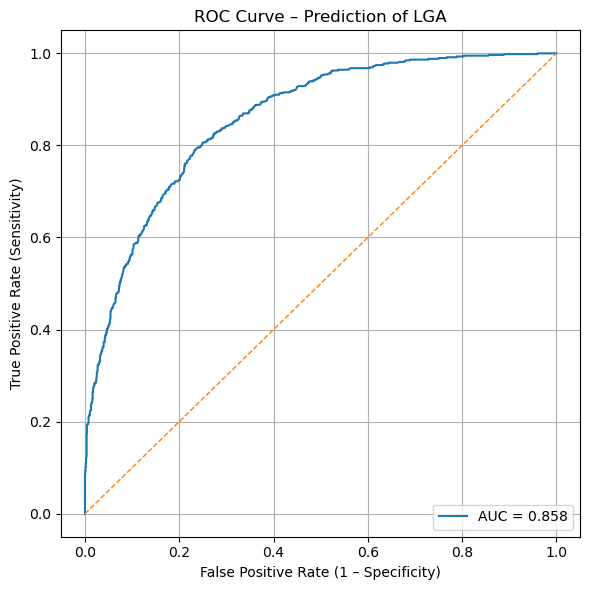

In [107]:
y_scr_male  = male["predicted_bw_brenner"].values
fpr_male, tpr_male, thresholds_male = roc_curve(y_true_male, y_scr_male)
auc_male = roc_auc_score(y_true_male, y_scr_male)

plt.figure(figsize=(6, 6))
plt.plot(fpr_male, tpr_male, label=f"AUC = {auc_male:.3f}")
plt.plot([0, 1], [0, 1], "--", linewidth=1)
plt.xlabel("False Positive Rate (1 – Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("ROC Curve – Prediction of LGA")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [108]:
female = merged[merged["sex_of_inf"]=="2:Female"]
female

,MRN,Date___Time,hospcode,reszip5,sex_of_inf,plurality,birth_orde,birth_wgt,mom_medrec,mom_whi,...,predicted_bw_brenner,error_brenner,abs_error_brenner,pct_error_brenner,abs_pct_error_brenner,log_AWE,wt_p90_a,LGA_actual,LGA_predicted,LGA_false_pos
1,008177,2014-01-31,Highland,14620.0,2:Female,1:Single,single,3419,008177,1:Yes,...,3253,-166,166,-4.855221,4.855221,5.117994,3918.0,0,0,0
3,020567,2015-02-26,Highland,14586.0,2:Female,1:Single,single,2929,020567,1:Yes,...,2968,39,39,1.331512,1.331512,3.688879,3940.0,0,0,0
7,035429,2014-04-22,Highland,14616.0,2:Female,1:Single,single,3410,035429,1:Yes,...,3841,431,431,12.639296,12.639296,6.068426,3962.0,0,0,0
8,037486,2015-03-05,Highland,14616.0,2:Female,1:Single,single,3459,037486,1:Yes,...,3441,-18,18,-0.520382,0.520382,2.944439,3768.0,0,0,0
11,043933,2015-03-24,Highland,14619.0,2:Female,1:Single,single,3935,043933,0:No,...,3887,-48,48,-1.219822,1.219822,3.89182,4021.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6069,E995848,2021-04-07,Strong,14606.0,2:Female,1:Single,single,3480,E995848,0:No,...,3745,265,265,7.614943,7.614943,5.583496,3651.0,0,1,1
6074,E996890,2023-05-19,Strong,14623.0,2:Female,1:Single,single,3110,E996890,0:No,...,3197,87,87,2.797428,2.797428,4.477337,3588.0,0,0,0
6075,E996991,2021-11-03,Strong,14534.0,2:Female,1:Single,single,3240,E996991,1:Yes,...,3502,262,262,8.08642,8.08642,5.572154,3451.0,0,1,1
6076,E998249,2020-04-22,Strong,14428.0,2:Female,1:Single,single,3960,E998249,1:Yes,...,3959,-1,1,-0.025253,0.025253,0.693147,3940.0,1,1,0


In [109]:
a_lga_n_female = female["LGA_actual"].sum()
a_lga_pct_female   = female["LGA_actual"].mean()*100
print(a_lga_n_female, f"{a_lga_pct_female:.2f}%")

312 13.80%


In [110]:
p_lga_n_female = female["LGA_predicted"].sum()
p_lga_pct_female = female["LGA_predicted"].mean() * 100
print(p_lga_n_female, f"{p_lga_pct_female:.2f}%")

489 21.63%


In [111]:
# % of babies predicted lga- but actually not lga-
female["LGA_false_pos"] = np.where(
    (female["LGA_predicted"] == 1) & (female["LGA_actual"] == 0), 1, 0
)

fp_n_female   = female["LGA_false_pos"].sum()
fp_pct_female = fp_n_female / len(female) * 100          # percent of *all* babies
print(fp_n_female, f"{fp_pct_female:.2f}%")

234 10.35%


/var/folders/nw/3jwfxsxs5hjf1kw6d5bq2bnw0000gn/T/ipykernel_15655/1056438335.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  female["LGA_false_pos"] = np.where(


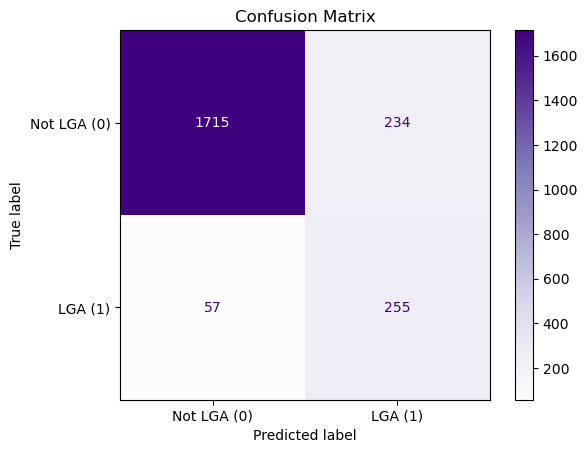

In [112]:
y_true_female = female["LGA_actual"].astype(int).values       
y_pred_female = female["LGA_predicted"].astype(int).values    
cm_female = confusion_matrix(y_true_female, y_pred_female)

labels = ["Not LGA (0)", "LGA (1)"]
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_female, display_labels=labels)
disp_train.plot(cmap='Purples')
plt.title("Confusion Matrix")
plt.show()

In [113]:
tn_female, fp_female, fn_female, tp_female = cm_female.ravel()
sensitivity_female = tp_female / (tp_female + fn_female)          # recall, TPR
specificity_female = tn_female / (tn_female + fp_female)          # TNR
accuracy_female    = (tp_female + tn_female) / (tp_female + fp_female + fn_female + tn_female)
print(f"Sensitivity: {sensitivity_female:.3%}")
print(f"Specificity: {specificity_female:.3%}")
print(f"Accuracy: {accuracy_female:.3%}")

fpr_female = fp_female / (fp_female + tn_female)           # False‑Positive Rate
fpr_female_ci     = wilson_ci(fp_female, fp_female + tn_female)
fdr_female = fp_female / (tp_female + fp_female)           # False‑Discovery Rate

print(f"FPR  (1‑Specificity): {fpr_female:.3%} {fpr_female_ci}")
print(f"FDR  (1‑PPV)       : {fdr_female:.3%}")

Sensitivity: 81.731%
Specificity: 87.994%
Accuracy: 87.130%
FPR  (1‑Specificity): 12.006% (0.10637342014575464, 0.1352445380132686)
FDR  (1‑PPV)       : 47.853%


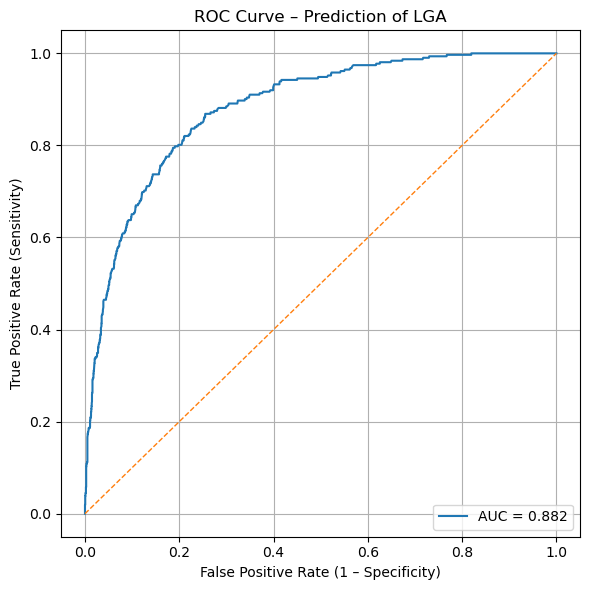

In [114]:
y_scr_female  = female["predicted_bw_brenner"].values
fpr_female, tpr_female, thresholds_female = roc_curve(y_true_female, y_scr_female)
auc_female = roc_auc_score(y_true_female, y_scr_female)

plt.figure(figsize=(6, 6))
plt.plot(fpr_female, tpr_female, label=f"AUC = {auc_female:.3f}")
plt.plot([0, 1], [0, 1], "--", linewidth=1)
plt.xlabel("False Positive Rate (1 – Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("ROC Curve – Prediction of LGA")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [115]:
n_male_neg  = fp_male  + tn_male    # denominator for pre-term FPR
n_female_neg = fp_female + tn_female   # denominator for term FPR
count = np.array([fp_male, fp_female])
nobs  = np.array([n_male_neg, n_female_neg])
# Two-sample proportion z-test (two-sided) comparing FPRs
z_stat, p_z = proportions_ztest(count, nobs, alternative='two-sided')

# 95% CI for absolute FPR difference (female − male)
# confint_proportions_2indep returns CI for p1 - p2, so pass term as 1 and pre-term as 2
ci_low, ci_upp = confint_proportions_2indep(
    count1 = fp_female, nobs1 = n_female_neg,   # female
    count2 = fp_male,  nobs2 = n_male_neg,    # male
    method = "wald"
)

# 3) Fisher exact test as robustness check (on negatives only)
#     2x2 table: rows=group, cols=FP vs TN among true non-LGA
# -----------------------------------------------------------
table = np.array([[fp_male,  tn_male],
                  [fp_female, tn_female]])

oddsratio, p_fisher = fisher_exact(table, alternative='two-sided')

# -----------------------------------------------------------
# 4) Display results
# -----------------------------------------------------------
fpr_male  = fp_male  / n_male_neg
fpr_female = fp_female / n_female_neg
diff     = fpr_female - fpr_male

print(f"Male FPR (FP/(FP+TN)): {fp_male}/{n_male_neg} = {fpr_male:.2%}")
print(f"Female    FPR (FP/(FP+TN)): {fp_female}/{n_female_neg} = {fpr_female:.2%}\n")

print(f"Two-sample z-test on FPRs:  z = {z_stat:.2f},  p = {p_z:.4f}")
print(f"Absolute FPR difference (female − male): {diff:.3%}")
print(f"95% CI for (female − male): {ci_low:.3%} to {ci_upp:.3%}")

print(f"\nFisher exact test on negatives only:  OR = {oddsratio:.2f},  p = {p_fisher:.4f}")


Male FPR (FP/(FP+TN)): 235/1717 = 13.69%
Female    FPR (FP/(FP+TN)): 234/1949 = 12.01%

Two-sample z-test on FPRs:  z = 1.52,  p = 0.1285
Absolute FPR difference (female − male): -1.681%
95% CI for (female − male): -3.854% to 0.493%

Fisher exact test on negatives only:  OR = 1.16,  p = 0.1372


## Predicted GA be 40W

In [116]:
# ─── C) Interpolated version of predicted_bw ────────────────────────────────
def compute_predicted_bw_40(row,mode):
    # pick the right interp‐function
    if mode == 'brenner':
        med_dict,f = brenner,interp_brenner
    elif mode == 'who_general':
        med_dict,f = who_general,interp_who_general
    elif mode == 'intergrowth':
        med_dict,f = intergrowth,interp_intergrowth
    elif mode == 'who_sex':
        if row['sex_of_inf'] == '2:Female':
            med_dict,f = who_female, interp_who_female
        elif row['sex_of_inf'] == '1:Male':
            med_dict,f = who_male,interp_who_male
        else:
            return pd.NA
    else:
        return pd.NA
    
    # handle missing f_weight
    if pd.isna(row['f_weight']) or row['f_weight'] == 0:
        return pd.NA

    # compute the valid day‐range from med_dict
    min_wk, max_wk = min(med_dict), max(med_dict)
    min_day, max_day = min_wk * 7, max_wk * 7

    # if either day is out of range, return NA
    if not (min_day <= row['ultra_days'] <= max_day) or not (min_day <= row['deliv_days'] <= max_day):
        return pd.NA

    # get the median at the exact day
    med_u = f(row['ultra_days'])
    med_d = f(40*7)
    
    # formula
    return int(med_d * row['f_weight'] / med_u)

merged_40 = merged[merged["ultra_days"] <= 40 * 7].copy()
merged_40['predicted_bw_brenner_40'] = merged_40.apply(compute_predicted_bw_40, axis=1,args=('brenner',)).astype("Int64")

In [117]:
merged_40.shape

(3968, 223)

In [118]:
merged_40['predicted_bw_brenner_40'].describe()

count         3968.0
mean     3533.017893
std       503.489719
min           2041.0
25%          3201.75
50%           3505.0
75%          3851.25
max           5492.0
Name: predicted_bw_brenner_40, dtype: Float64

In [119]:
# Number of predicted LGA 
p90_40_girls = p90_girls[40*7]
p90_40_boys = p90_boys[40*7]
merged_40["LGA_predicted_40"] = np.where(
    merged_40["sex_of_inf"] == '2:Female',
    (merged_40["predicted_bw_brenner_40"] > p90_40_girls).astype("int8"),
    (merged_40["predicted_bw_brenner_40"] > p90_40_boys).astype("int8")
)
p_lga_n_40 = merged_40["LGA_predicted_40"].sum()
p_lga_40   = merged_40["LGA_predicted_40"].mean()*100
print(p_lga_n_40, f"{p_lga_40:.2f}%")

729 18.37%


In [120]:
# % of babies predicted lga- but actually not lga-
merged_40["LGA_false_pos_40"] = np.where(
    (merged_40["LGA_predicted_40"] == 1) & (merged_40["LGA_actual"] == 0), 1, 0
)

fp_n_40   = merged_40["LGA_false_pos_40"].sum()
fp_pct_40 = fp_n_40 / len(merged_40) * 100          # percent of *all* babies
print(fp_n_40, f"{fp_pct_40:.2f}%")

232 5.85%


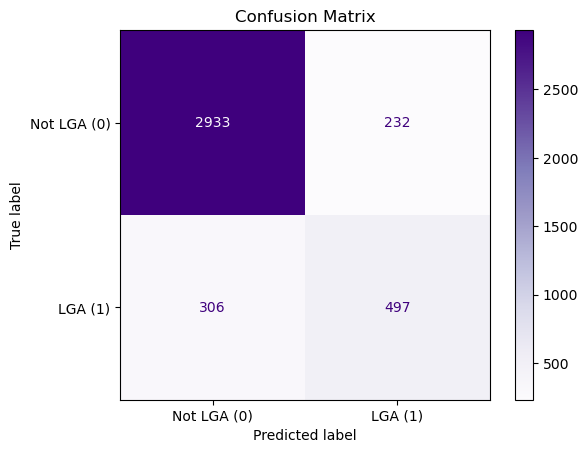

In [121]:
y_true_40 = merged_40["LGA_actual"].astype(int).values       
y_pred_40 = merged_40["LGA_predicted_40"].astype(int).values    
cm_40 = confusion_matrix(y_true_40, y_pred_40)

labels = ["Not LGA (0)", "LGA (1)"]
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_40, display_labels=labels)
disp_train.plot(cmap='Purples')
plt.title("Confusion Matrix")
plt.show()

In [122]:
tn_40, fp_40, fn_40, tp_40 = cm_40.ravel()
sensitivity_40 = tp_40 / (tp_40 + fn_40)          # recall, TPR
specificity_40 = tn_40 / (tn_40 + fp_40)          # TNR
accuracy_40    = (tp_40 + tn_40) / (tp_40 + fp_40 + fn_40 + tn_40)
print(f"Sensitivity: {sensitivity_40:.3%}")
print(f"Specificity: {specificity_40:.3%}")
print(f"Accuracy: {accuracy_40:.3%}")

fpr_40 = fp_40 / (fp_40 + tn_40)           # False‑Positive Rate
fdr_40 = fp_40 / (tp_40 + fp_40)           # False‑Discovery Rate
print(f"FPR  (1‑Specificity): {fpr_40:.3%}")
print(f"FDR  (1‑PPV)       : {fdr_40:.3%}")

Sensitivity: 61.893%
Specificity: 92.670%
Accuracy: 86.442%
FPR  (1‑Specificity): 7.330%
FDR  (1‑PPV)       : 31.824%


In [123]:
from statsmodels.stats.contingency_tables import mcnemar

# ------------------------------------------------------------------
# 1. Create paired 0/1 vectors for each pregnancy
# ------------------------------------------------------------------
# y_primary   : predicted LGA label using the actual GA at birth
# y_fixed39   : predicted label assuming delivery at 39+0 weeks
# y_fixed40   : predicted label assuming delivery at 40+0 weeks
# (length of each vector = number of pregnancies retained in the scenario)

# ------------------------------------------------------------------
# 2. McNemar test for the 40-week projection
# ------------------------------------------------------------------
# Build the 2×2 table:
#               fixed39 = 1   fixed39 = 0
# primary = 1       a             b
# primary = 0       c             d
a = np.sum((merged["LGA_predicted"] == 1) & (merged_40["LGA_predicted_40"] == 1))
b = np.sum((merged["LGA_predicted"] == 1) & (merged_40["LGA_predicted_40"] == 0))
c = np.sum((merged["LGA_predicted"] == 0) & (merged_40["LGA_predicted_40"] == 1))
d = np.sum((merged["LGA_predicted"] == 0) & (merged_40["LGA_predicted_40"] == 0))
table40 = [[a, b],
           [c, d]]

result40 = mcnemar(table40, exact=False, correction=True)
print(f"40-week projection:  χ² = {result40.statistic:.2f},  P = {result40.pvalue:.4f}")


40-week projection:  χ² = 290.58,  P = 0.0000


## Predicted GA be 39W

In [124]:
# ─── C) Interpolated version of predicted_bw ────────────────────────────────
def compute_predicted_bw_39(row,mode):
    # pick the right interp‐function
    if mode == 'brenner':
        med_dict,f = brenner,interp_brenner
    elif mode == 'who_general':
        med_dict,f = who_general,interp_who_general
    elif mode == 'intergrowth':
        med_dict,f = intergrowth,interp_intergrowth
    elif mode == 'who_sex':
        if row['sex_of_inf'] == '2:Female':
            med_dict,f = who_female, interp_who_female
        elif row['sex_of_inf'] == '1:Male':
            med_dict,f = who_male,interp_who_male
        else:
            return pd.NA
    else:
        return pd.NA
    
    # handle missing f_weight
    if pd.isna(row['f_weight']) or row['f_weight'] == 0:
        return pd.NA

    # compute the valid day‐range from med_dict
    min_wk, max_wk = min(med_dict), max(med_dict)
    min_day, max_day = min_wk * 7, max_wk * 7

    # if either day is out of range, return NA
    if not (min_day <= row['ultra_days'] <= max_day) or not (min_day <= row['deliv_days'] <= max_day):
        return pd.NA

    # get the median at the exact day
    med_u = f(row['ultra_days'])
    med_d = f(39*7)
    
    # formula
    return int(med_d * row['f_weight'] / med_u)
merged_39 = merged[merged["ultra_days"] <= 39 * 7].copy()
merged_39['predicted_bw_brenner_39'] = merged_39.apply(compute_predicted_bw_39, axis=1,args=('brenner',)).astype("Int64")

In [125]:
merged_39['predicted_bw_brenner_39'].describe()

count         3609.0
mean     3412.126351
std       490.875247
min           1972.0
25%           3091.0
50%           3386.0
75%           3724.0
max           5308.0
Name: predicted_bw_brenner_39, dtype: Float64

In [126]:
# Number of predicted LGA 
p90_39_girls = p90_girls[39*7]
p90_39_boys = p90_boys[39*7]
merged_39["LGA_predicted_39"] = np.where(
    merged_39["sex_of_inf"] == '2:Female',
    (merged_39["predicted_bw_brenner_39"] > p90_39_girls).astype("int8"),
    (merged_39["predicted_bw_brenner_39"] > p90_39_boys).astype("int8")
)
p_lga_n_39 = merged_39["LGA_predicted_39"].sum()
p_lga_39   = merged_39["LGA_predicted_39"].mean()*100
print(p_lga_n_39, f"{p_lga_39:.2f}%")

778 21.56%


In [127]:
# % of babies predicted lga- but actually not lga-
merged_39["LGA_false_pos_39"] = np.where(
    (merged_39["LGA_predicted_39"] == 1) & (merged_39["LGA_actual"] == 0), 1, 0
)

fp_n_39   = merged_39["LGA_false_pos_39"].sum()
fp_pct_39 = fp_n_39 / len(merged_39) * 100          # percent of *all* babies
print(fp_n_39, f"{fp_pct_39:.2f}%")

266 7.37%


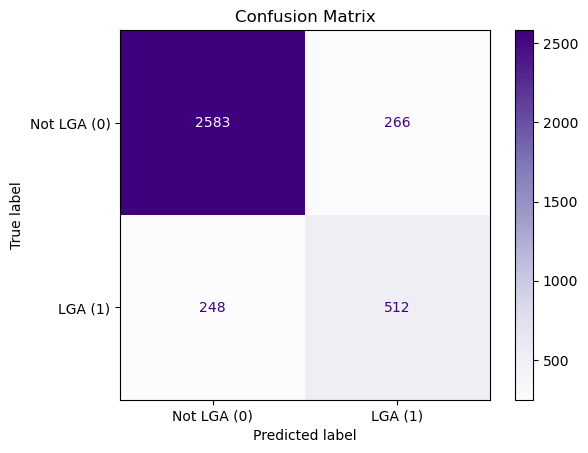

In [128]:
y_true_39 = merged_39["LGA_actual"].astype(int).values       
y_pred_39 = merged_39["LGA_predicted_39"].astype(int).values    
cm_39 = confusion_matrix(y_true_39, y_pred_39)

labels = ["Not LGA (0)", "LGA (1)"]
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_39, display_labels=labels)
disp_train.plot(cmap='Purples')
plt.title("Confusion Matrix")
plt.show()

In [129]:
tn_39, fp_39, fn_39, tp_39 = cm_39.ravel()
sensitivity_39 = tp_39 / (tp_39 + fn_39)          # recall, TPR
specificity_39 = tn_39 / (tn_39 + fp_39)          # TNR
accuracy_39    = (tp_39 + tn_39) / (tp_39 + fp_39 + fn_39 + tn_39)
print(f"Sensitivity: {sensitivity_39:.3%}")
print(f"Specificity: {specificity_39:.3%}")
print(f"Accuracy: {accuracy_39:.3%}")

fpr_39 = fp_39 / (fp_39 + tn_39)           # False‑Positive Rate
fdr_39 = fp_39 / (tp_39 + fp_39)           # False‑Discovery Rate
print(f"FPR  (1‑Specificity): {fpr_39:.3%}")
print(f"FDR  (1‑PPV)       : {fdr_39:.3%}")

Sensitivity: 67.368%
Specificity: 90.663%
Accuracy: 85.758%
FPR  (1‑Specificity): 9.337%
FDR  (1‑PPV)       : 34.190%


In [130]:
# ------------------------------------------------------------------
# 3. McNemar test for the 39-week projection
# ------------------------------------------------------------------
a = np.sum((merged["LGA_predicted"] == 1) & (merged_39["LGA_predicted_39"] == 1))
b = np.sum((merged["LGA_predicted"] == 1) & (merged_39["LGA_predicted_39"] == 0))
c = np.sum((merged["LGA_predicted"] == 0) & (merged_39["LGA_predicted_39"] == 1))
d = np.sum((merged["LGA_predicted"] == 0) & (merged_39["LGA_predicted_39"] == 0))
table39 = [[a, b],
           [c, d]]

result39 = mcnemar(table39, exact=False, correction=True)
print(f"39-week projection:  χ² = {result39.statistic:.2f},  P = {result39.pvalue:.4f}")

39-week projection:  χ² = 132.55,  P = 0.0000


## Replicate 

In [131]:
uniq = sorted(merged["pres_del"].dropna().unique().tolist())
print(uniq)

['1:Cephalic', '2:Breech', '3:Other']


In [132]:
merged["num_cs"].describe()

count    4568.000000
mean        0.452496
std         4.871812
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        99.000000
Name: num_cs, dtype: float64

In [133]:
# If the column is already numeric
n_99 = merged["num_cs"].eq(99).sum()
print("Count of 99:", n_99)
merged["num_cs"] = merged["num_cs"].mask(merged["num_cs"].eq(99))  # 99 → NaN

Count of 99: 11


In [134]:
merged["infec_hsv"].unique()

array(['1:Yes', '0:No'], dtype=object)

In [135]:
replicate = merged.loc[
    (merged["pres_del"] == "1:Cephalic") &
    (merged["num_cs"] < 3) &
    (merged["infec_hsv"] == "0:No") &
    (~merged["indications"].str.contains(r"\bprevia\b", case=False, na=False))
].copy()

replicate

,MRN,Date___Time,hospcode,reszip5,sex_of_inf,plurality,birth_orde,birth_wgt,mom_medrec,mom_whi,...,predicted_bw_brenner,error_brenner,abs_error_brenner,pct_error_brenner,abs_pct_error_brenner,log_AWE,wt_p90_a,LGA_actual,LGA_predicted,LGA_false_pos
1,008177,2014-01-31,Highland,14620.0,2:Female,1:Single,single,3419,008177,1:Yes,...,3253,-166,166,-4.855221,4.855221,5.117994,3918.0,0,0,0
2,018533,2014-06-03,Highland,14618.0,1:Male,1:Single,single,3538,018533,1:Yes,...,3724,186,186,5.257207,5.257207,5.231109,3451.0,1,1,0
3,020567,2015-02-26,Highland,14586.0,2:Female,1:Single,single,2929,020567,1:Yes,...,2968,39,39,1.331512,1.331512,3.688879,3940.0,0,0,0
5,028300,2015-03-26,Highland,14425.0,1:Male,1:Single,single,4278,028300,1:Yes,...,3587,-691,691,-16.152408,16.152408,6.539586,4088.0,1,0,0
6,032890,2015-04-08,Highland,14612.0,1:Male,1:Single,single,3481,032890,1:Yes,...,3358,-123,123,-3.533467,3.533467,4.820282,3918.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6072,E996508,2023-01-05,Strong,14450.0,1:Male,1:Single,single,3160,E996508,1:Yes,...,2902,-258,258,-8.164557,8.164557,5.556828,3982.0,0,0,0
6074,E996890,2023-05-19,Strong,14623.0,2:Female,1:Single,single,3110,E996890,0:No,...,3197,87,87,2.797428,2.797428,4.477337,3588.0,0,0,0
6075,E996991,2021-11-03,Strong,14534.0,2:Female,1:Single,single,3240,E996991,1:Yes,...,3502,262,262,8.08642,8.08642,5.572154,3451.0,0,1,1
6076,E998249,2020-04-22,Strong,14428.0,2:Female,1:Single,single,3960,E998249,1:Yes,...,3959,-1,1,-0.025253,0.025253,0.693147,3940.0,1,1,0


In [136]:
uniq = sorted(replicate["route_main"].dropna().unique().tolist())
print(uniq)

['1:spontaneous', '3:forceps-low/outlet', '4:vacuum', '5:cesarean']


In [137]:
map_exact = {
    "1:spontaneous": 0,
    "3:forceps-low/outlet": 0,
    "4:vacuum": 0,
    "5:cesarean": 1,
}
replicate["cd_any"] = replicate["route_main"].map(map_exact)

In [138]:
replicate["cd_any"].sum()

1131

In [139]:
replicate["cd_any"].mean()

0.2847432024169184

In [140]:
replicate["pre_preg_wt"].mean()

170.82881935314225

In [141]:
replicate["mom_ht"].mean()

64.37853535353536

In [142]:
LB_TO_KG = 0.453592
IN_TO_M  = 0.0254

wt_kg = replicate["pre_preg_wt"] * LB_TO_KG
ht_m  = replicate["mom_ht"] * IN_TO_M
replicate["bmi"] = wt_kg / (ht_m ** 2)

replicate["bmi_cat"] = pd.cut(
    replicate["bmi"],
    bins=[-np.inf, 25, 30, 40, np.inf],
    labels=["<25", "25-29.9", "30-39.9", ">=40"],
    right=False
)

In [143]:
replicate["diabetes_m"].unique()

array(['0:No', '1:Yes'], dtype=object)

In [144]:
bin_cols = ["diabetes_g", "diabetes_m", "hyper_preg", "hyper_chro"]

for c in bin_cols:
    s = replicate[c].astype("string").str.strip()
    replicate[c] = s.map({"1:Yes": 1, "0:No": 0}).astype("Int64")  # others → <NA>

# combined flags
replicate["diab_any"] = ((replicate["diabetes_g"]==1) | (replicate["diabetes_m"]==1)).astype("Int64")
replicate["htn_any"]  = ((replicate["hyper_preg"]==1) | (replicate["hyper_chro"]==1)).astype("Int64")

In [145]:
replicate["mom_whi"].unique()

array(['1:Yes', '0:No'], dtype=object)

In [146]:
replicate["mhis_no"].unique()

array(['Not Hispanic', 'Hispanic'], dtype=object)

In [147]:
# Hispanic (takes precedence)
hisp = replicate["mhis_no"].map({
    "Hispanic": 1,
    "Not Hispanic": 0
}).astype("Int64")  

# Race dummies we have (use whatever exists in your dataframe)
race_cols = [
    "mom_whi","mom_bla","mom_si","mom_chi","mom_fil","mom_jap","mom_kor","mom_vie",
    "mom_nha","mom_gua","mom_sam","mom_aina","mom_oas","mom_opi","mom_oth"
]
race_cols = [c for c in race_cols if c in replicate.columns]

for c in race_cols:
    replicate[c] = replicate[c].map({"1:Yes":1, "0:No":0})


In [148]:
hisp.sum()

338

In [149]:
replicate["mom_whi"]

1       1
2       1
3       1
5       1
6       1
       ..
6072    1
6074    0
6075    1
6076    1
6078    1
Name: mom_whi, Length: 3972, dtype: int64

In [150]:
white = replicate["mom_whi"]
black = replicate["mom_bla"]

# 2) Count number of race flags per person
race_count = replicate[race_cols].sum(axis=1)

# 4) build race_cat with your precedence
replicate["race_cat"] = "None of the above"                                  # default
replicate.loc[race_count >= 2, "race_cat"] = "None of the above"             # multiracial → None
replicate.loc[hisp == 1, "race_cat"] = "Hispanic"                            # Hispanic overrides
replicate.loc[(hisp == 0) & (white == 1) & (race_count == 1), "race_cat"] = "White"
replicate.loc[(hisp == 0) & (black == 1) & (race_count == 1), "race_cat"] = "Black"

# 5) categorical (order just for display)
replicate["race_cat"] = pd.Categorical(
    replicate["race_cat"],
    categories=["White","Black","Hispanic","None of the above"]
)

print(replicate["race_cat"].value_counts(dropna=False))

race_cat
White                2541
Black                 751
None of the above     342
Hispanic              338
Name: count, dtype: int64


In [151]:
replicate["hyper_preg"].unique()

<IntegerArray>
[0, 1]
Length: 2, dtype: Int64

In [152]:
replicate["trial_lab"] = (
    replicate["trial_lab"].map({"1:Yes":1,"0:No":0})
       .astype("Int64")   # nullable int, preserves NaN
)

# Nulliparity 
v = pd.to_numeric(replicate["calc_birth_all"], errors="coerce")
replicate["nulliparous"] = pd.Series(
    np.where(v.isna(), np.nan, np.where(v == 0, 1, 0)),
    index=replicate.index
).astype("Int64")

In [153]:
import numpy as np, pandas as pd
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.contingency_tables import Table2x2

# ===== CONFIG =====
df = replicate.copy()
TARGET = "LGA_predicted"         # Group 1 vs Group 0 (paper's Group 1/2)
use_mannwhitney_for = {"bmi"}    # add continuous vars here if clearly non-normal

# Make sure target is 0/1 int
df["target"] = pd.to_numeric(df[TARGET], errors="coerce").astype(int)

# Create neonatal macrosomia if not present
df["macrosomia_4500"] = (pd.to_numeric(df["birth_wgt"], errors="coerce") > 4500).astype("Int64")

# ----- helpers -----
def cont_row(var, label=None):
    x1 = pd.to_numeric(df.loc[df["target"]==1, var], errors="coerce")
    x0 = pd.to_numeric(df.loc[df["target"]==0, var], errors="coerce")
    m1, s1 = x1.mean(), x1.std(ddof=1)
    m0, s0 = x0.mean(), x0.std(ddof=1)
    if var in use_mannwhitney_for:
        _, p = stats.mannwhitneyu(x1.dropna(), x0.dropna(), alternative="two-sided")
    else:
        _, p = stats.ttest_ind(x1, x0, equal_var=False, nan_policy="omit")  # Welch t
    return {"Variable": label or var, "Group 1": f"{m1:.1f} ± {s1:.1f}",
            "Group 0": f"{m0:.1f} ± {s0:.1f}", "P": p}

def cat_bin_row(var, label=None, add_or=True):
    d = df[[var, "target"]].dropna().copy()
    d[var] = pd.to_numeric(d[var], errors="coerce")
    d["target"] = pd.to_numeric(d["target"], errors="coerce")
    d = d.dropna()
    if d[var].nunique()<2 or d["target"].nunique()<2:
        return {"Variable": label or var, "Group 1 n/%":"-", "Group 0 n/%":"-",
                "P": np.nan, "Crude OR (95% CI)": ""}

    # 2x2 table (rows=var 0/1, cols=target 0/1)
    tab = (pd.crosstab(d[var], d["target"])
             .reindex(index=[0,1], columns=[0,1], fill_value=0))
    a = int(tab.loc[1,1])  # var=1, target=1
    b = int(tab.loc[1,0])  # var=1, target=0
    c = int(tab.loc[0,1])  # var=0, target=1
    d0= int(tab.loc[0,0])  # var=0, target=0
    n1 = a + c             # total in Group 1 among non-missing
    n0 = b + d0            # total in Group 0 among non-missing

    # Default outputs
    p_val = np.nan
    or_txt = ""

    # Try logistic first (paper method)
    try:
        m = sm.Logit(d["target"], sm.add_constant(d[var].astype(float))).fit(disp=0)
        p_val = float(m.pvalues[var])
        if add_or:
            beta = float(m.params[var])
            lo, hi = m.conf_int().loc[var].astype(float).tolist()
            OR  = np.exp(beta); OR_lo = np.exp(lo); OR_hi = np.exp(hi)
            or_txt = f"{OR:.2f} [{OR_lo:.2f}, {OR_hi:.2f}]"
    except Exception:
        # Separation or failure → fallback to exact/2x2 methods
        if add_or:
            # Haldane-Anscombe correction if any zero cell
            a_, b_, c_, d_ = (a, b, c, d0)
            if 0 in [a_, b_, c_, d_]:
                a_, b_, c_, d_ = [x + 0.5 for x in (a_, b_, c_, d_)]
            t22 = Table2x2([[a_, b_], [c_, d_]])
            OR = t22.oddsratio
            OR_lo, OR_hi = t22.oddsratio_confint()
            or_txt = f"{OR:.2f} [{OR_lo:.2f}, {OR_hi:.2f}]"
        # Fisher’s exact p (two-sided) if 2x2
        _, p_val = stats.fisher_exact([[a, b], [c, d0]])

    return {
        "Variable": label or var,
        "Group 1 n/%": f"{a}/{n1} ({(a/max(n1,1))*100:.1f}%)",
        "Group 0 n/%": f"{b}/{n0} ({(b/max(n0,1))*100:.1f}%)",
        "P": p_val,
        "Crude OR (95% CI)": or_txt
    }

def _or_ci_from_2x2(a, b, c, d):
    """Crude OR and 95% CI from a 2x2; adds 0.5 if any zero cell."""
    if 0 in (a, b, c, d):
        a, b, c, d = a+0.5, b+0.5, c+0.5, d+0.5
    t = Table2x2([[a, b], [c, d]])
    OR = t.oddsratio
    lo, hi = t.oddsratio_confint()
    return OR, lo, hi

def cat_multi_block(var, label=None, order=None, add_or=True):
    """
    Multi-level categorical to match the paper:
      - header row (no overall p)
      - one row PER LEVEL with counts/%, univariate logistic p, and crude OR vs all others.
    """
    d = df[[var, "target"]].dropna().copy()
    if d.empty or d[var].nunique() < 2 or d["target"].nunique() < 2:
        return [{"Variable": label or var,
                 "Group 1 n/%": "-", "Group 0 n/%": "-",
                 "P": "", "Crude OR (95% CI)": ""}]

    # denominators among non-missing rows for this var
    n1 = int((d["target"] == 1).sum())
    n0 = int((d["target"] == 0).sum())

    # display order of levels
    if order is None:
        if pd.api.types.is_categorical_dtype(d[var]):
            levels = list(d[var].cat.categories)
        else:
            levels = list(pd.unique(d[var]))
    else:
        levels = [lvl for lvl in order if lvl in d[var].unique()]

    rows = [{
        "Variable": label or var,
        "Group 1 n/%": "", "Group 0 n/%": "",
        "P": "", "Crude OR (95% CI)": ""
    }]

    for lvl in levels:
        # 1 vs all others indicator
        mask = (d[var] == lvl).astype(int)

        # cells of the 2x2 table
        a = int(((mask == 1) & (d["target"] == 1)).sum())  # level in Group 1
        b = int(((mask == 1) & (d["target"] == 0)).sum())  # level in Group 0
        c = n1 - a                                         # others in Group 1
        d0 = n0 - b                                        # others in Group 0

        # logistic p-value and crude OR (with 95% CI)
        p_val, or_txt = np.nan, ""
        try:
            X = sm.add_constant(mask.astype(float))
            m = sm.Logit(d["target"], X).fit(disp=0)
            p_val = float(m.pvalues[1])  # coef of the indicator
            if add_or:
                beta = float(m.params[1])
                lo, hi = m.conf_int().iloc[1].astype(float).tolist()
                OR, OR_lo, OR_hi = np.exp(beta), np.exp(lo), np.exp(hi)
                or_txt = f"{OR:.2f} [{OR_lo:.2f}, {OR_hi:.2f}]"
        except Exception:
            # separation fallback
            if add_or:
                OR, OR_lo, OR_hi = _or_ci_from_2x2(a, b, c, d0)
                or_txt = f"{OR:.2f} [{OR_lo:.2f}, {OR_hi:.2f}]"
            _, p_val = stats.fisher_exact([[a, b], [c, d0]])

        rows.append({
            "Variable": f"  {lvl}",
            "Group 1 n/%": f"{a}/{n1} ({(a/max(n1,1))*100:.1f}%)",
            "Group 0 n/%": f"{b}/{n0} ({(b/max(n0,1))*100:.1f}%)",
            "P": p_val,
            "Crude OR (95% CI)": or_txt
        })

    return rows

# ----- assemble rows to mirror paper -----
rows = []

# Demographics
if "mom_age" in df: rows.append(cont_row("mom_age", "Maternal age"))
for cut, lab in [(35, "Age ≥35"), (40, "Age ≥40")]:
    if "mom_age" in df:
        df[f"age_ge{cut}"] = (pd.to_numeric(df["mom_age"], errors="coerce") >= cut).astype("Int64")
        rows.append(cat_bin_row(f"age_ge{cut}", lab))

# Race (multi-level with counts + overall p)
if "race_cat" in df:
    desired = ["Black","Hispanic","White","None of the above"]
    present_order = [x for x in desired if x in df["race_cat"].dropna().unique().tolist()]
    rows += cat_multi_block("race_cat", label="Race", order=present_order)

# Nulliparity (if present)
rows.append(cat_bin_row("nulliparous", "Nulliparous (Y)"))

# BMI section
if "bmi" in df: rows.append(cont_row("bmi", "BMI"))
if "bmi_cat" in df:
    bmi_order = ["<25","25-29.9","30-39.9",">=40"]
    present_bmi = [b for b in bmi_order if b in df["bmi_cat"].dropna().unique().tolist()]
    rows += cat_multi_block("bmi_cat", label="BMI category", order=present_bmi)

# Diabetes (separate rows like the paper) + crude ORs
if "diabetes_g" in df: rows.append(cat_bin_row("diabetes_g", "Diabetes – Gestational"))
if "diabetes_m" in df: rows.append(cat_bin_row("diabetes_m", "Diabetes – Pregestational"))

# Preeclampsia from 'hyper_preg' coded exactly "1:Yes"/"0:No"
if "hyper_preg" in df.columns:
    rows.append(cat_bin_row("hyper_preg", "Preeclampsia diagnosis (Y)"))

# Neonatal (descriptive)
if "birth_wgt" in df: rows.append(cont_row("birth_wgt", "Birthweight (g)"))
if "macrosomia_4500" in df: rows.append(cat_bin_row("macrosomia_4500", "Neonatal macrosomia (>4500 g)"))
if "LGA_actual" in df: rows.append(cat_bin_row("LGA_actual", "LGA neonate (≥90th %ile)"))

# ----- finalize table -----
table2 = pd.DataFrame(rows)
table2["P"] = table2["P"].map(lambda x: f"{x:.3f}" if isinstance(x,(int,float,np.floating)) else x)
table2


/var/folders/nw/3jwfxsxs5hjf1kw6d5bq2bnw0000gn/T/ipykernel_15655/2429892506.py:140: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_val = float(m.pvalues[1])  # coef of the indicator
/var/folders/nw/3jwfxsxs5hjf1kw6d5bq2bnw0000gn/T/ipykernel_15655/2429892506.py:142: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = float(m.params[1])
/var/folders/nw/3jwfxsxs5hjf1kw6d5bq2bnw0000gn/T/ipykernel_15655/2429892506.py:140: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by

,Variable,Group 1,Group 0,P,Group 1 n/%,Group 0 n/%,Crude OR (95% CI)
0,Maternal age,31.4 ± 4.9,30.0 ± 5.4,0.000,NaN,NaN,NaN
1,Age ≥35,NaN,NaN,0.000,278/1024 (27.1%),594/2948 (20.1%),"1.48 [1.25, 1.74]"
2,Age ≥40,NaN,NaN,0.411,40/1024 (3.9%),99/2948 (3.4%),"1.17 [0.80, 1.70]"
3,Race,NaN,NaN,,,,
4,Black,NaN,NaN,0.000,127/1024 (12.4%),624/2948 (21.2%),"0.53 [0.43, 0.65]"
5,Hispanic,NaN,NaN,0.425,81/1024 (7.9%),257/2948 (8.7%),"0.90 [0.69, 1.17]"
6,White,NaN,NaN,0.000,743/1024 (72.6%),1798/2948 (61.0%),"1.69 [1.45, 1.98]"
7,None of the above,NaN,NaN,0.050,73/1024 (7.1%),269/2948 (9.1%),"0.76 [0.58, 1.00]"
8,Nulliparous (Y),NaN,NaN,0.000,229/1024 (22.4%),870/2948 (29.5%),"0.69 [0.58, 0.81]"
9,BMI,31.2 ± 8.6,28.1 ± 8.0,0.000,NaN,NaN,NaN


In [154]:
# --- pick the LGA cohort used in the flowchart ---
total = merged[merged["LGA_predicted"].astype(int) == 1].copy()
print(len(total))

sub = replicate[replicate["LGA_predicted"].astype(int) == 1].copy()
print(len(sub))
print (len(total)-len(sub))

# handy aliases
prior = pd.to_numeric(sub["num_cs"],  errors="coerce").fillna(0)
cd    = pd.to_numeric(sub["cd_any"],  errors="coerce")        # 1=CS, 0=Vag
lab   = pd.to_numeric(sub.get("trial_lab"), errors="coerce")  # 1=labored, 0=non-labored, NA often for vaginal
nulli = pd.to_numeric(sub.get("nulliparous"), errors="coerce") # 1=nulliparous

# --- counts for boxes ---
prior_cesarean            = (prior >= 1).sum()
print("prior_cesarean",prior_cesarean)
prior_cesarean_2plus      = (prior >= 2).sum()
print("prior_cesarean_2plus",prior_cesarean_2plus)
no_prior_cesarean         = (prior == 0).sum()
print("no_prior_cesarean",no_prior_cesarean)

# left branch: prior CS (requires 'trial_lab' to separate)
elective_repeat_cs        = ((prior >= 1) & cd.eq(1) & lab.eq(0)).sum()
print("elective_repeat_cs",elective_repeat_cs)

VBAC                      = ((prior >= 1) & cd.eq(0)).sum()
print("VBAC",VBAC)

VBAC_2plus                = ((prior >= 2) & cd.eq(0)).sum()
print("VBAC_2plus",VBAC_2plus)

failed_TOLAC_repeat_cs    = ((prior >= 1) & lab.eq(1) & cd.eq(1)).sum()
print("failed_TOLAC_repeat_cs",failed_TOLAC_repeat_cs)

TOLAC                    = VBAC + failed_TOLAC_repeat_cs
print("TOLAC",TOLAC)
TOLAC_2plus               =VBAC_2plus + ((prior.ge(2)) & cd.eq(1) & lab.eq(1)).sum()
print("TOLAC_2plus",TOLAC_2plus)


# right branch: no prior CS
no_prior_vaginal          = ((prior == 0) & cd.eq(0)).sum()
print("no_prior_vaginal",no_prior_vaginal)

no_prior_cesarean_only    = ((prior == 0) & cd.eq(1)).sum()
print("no_prior_cesarean_only",no_prior_cesarean_only)

NTSV_cesarean             = ((prior == 0) & cd.eq(1) & nulli.eq(1)).sum()
print("NTSV_cesarean",NTSV_cesarean)

primary_parous_cesarean   = ((prior == 0) & cd.eq(1) & nulli.eq(0)).sum()
print("primary_parous_cesarean",primary_parous_cesarean)

1181
1024
157
prior_cesarean 224
prior_cesarean_2plus 46
no_prior_cesarean 800
elective_repeat_cs 159
VBAC 34
VBAC_2plus 1
failed_TOLAC_repeat_cs 31
TOLAC 65
TOLAC_2plus 4
no_prior_vaginal 544
no_prior_cesarean_only 256
NTSV_cesarean 123
primary_parous_cesarean 133


In [155]:
# --- pick the NOT LGA cohort used in the flowchart ---
total = merged[merged["LGA_predicted"].astype(int) == 0].copy()
print(len(total))

sub = replicate[replicate["LGA_predicted"].astype(int) == 0].copy()
print(len(sub))
print (len(total)-len(sub))

# handy aliases
prior = sub["num_cs"]
cd    = pd.to_numeric(sub["cd_any"], errors="coerce")          # 1=cesarean, 0=vaginal
lab   = pd.to_numeric(sub.get("trial_lab"), errors="coerce")   # 1=labored (TOL), 0=non-labored
nulli = pd.to_numeric(sub.get("nulliparous"), errors="coerce") # 1=nulliparous

# --- counts for boxes ---
prior_cesarean            = (prior >= 1).sum()
print("prior_cesarean",prior_cesarean)
prior_cesarean_2plus      = (prior >= 2).sum()
print("prior_cesarean_2plus",prior_cesarean_2plus)
no_prior_cesarean         = (prior == 0).sum()
print("no_prior_cesarean",no_prior_cesarean)

# left branch: prior CS (requires 'trial_lab' to separate)
elective_repeat_cs        = ((prior >= 1) & cd.eq(1) & lab.eq(0)).sum()
print("elective_repeat_cs",elective_repeat_cs)

VBAC                      = ((prior >= 1) & cd.eq(0)).sum()
print("VBAC",VBAC)

VBAC_2plus                = ((prior >= 2) & cd.eq(0)).sum()
print("VBAC_2plus",VBAC_2plus)

failed_TOLAC_repeat_cs    = ((prior >= 1) & lab.eq(1) & cd.eq(1)).sum()
print("failed_TOLAC_repeat_cs",failed_TOLAC_repeat_cs)

TOLAC                    = VBAC + failed_TOLAC_repeat_cs
print("TOLAC",TOLAC)
TOLAC_2plus               =VBAC_2plus + ((prior.ge(2)) & cd.eq(1) & lab.eq(1)).sum()
print("TOLAC_2plus",TOLAC_2plus)

# right branch: no prior CS
no_prior_vaginal          = ((prior == 0) & cd.eq(0)).sum()
print("no_prior_vaginal",no_prior_vaginal)

no_prior_cesarean_only    = ((prior == 0) & cd.eq(1)).sum()
print("no_prior_cesarean_only",no_prior_cesarean_only)

NTSV_cesarean             = ((prior == 0) & cd.eq(1) & nulli.eq(1)).sum()
print("NTSV_cesarean",NTSV_cesarean)

primary_parous_cesarean   = ((prior == 0) & cd.eq(1) & nulli.eq(0)).sum()
print("primary_parous_cesarean",primary_parous_cesarean)

3387
2948
439
prior_cesarean 393
prior_cesarean_2plus 59
no_prior_cesarean 2555
elective_repeat_cs 208
VBAC 139
VBAC_2plus 7
failed_TOLAC_repeat_cs 46
TOLAC 185
TOLAC_2plus 10
no_prior_vaginal 2124
no_prior_cesarean_only 431
NTSV_cesarean 193
primary_parous_cesarean 238


In [184]:
# ==============================
# Imports
# ==============================
import numpy as np
import pandas as pd
from statsmodels.stats.contingency_tables import Table2x2
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import PerfectSeparationError

# ==============================
# 0) Setup & coercions
# ==============================
df = replicate.copy()

GROUP   = "LGA_predicted"   # exposure: 1 = diagnosed LGA on 3rd-trimester US
EFW_COL = "f_weight"        # EFW used for "medically indicated" rule

for col in [GROUP, "cd_any", "trial_lab", "num_cs", "nulliparous",
            "diabetes_g", "diabetes_m", "bmi", "mom_age", "birth_wgt"]:
    if col in df:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# exposure vector
G   = df[GROUP].astype("Int64")
ALL = pd.Series(True, index=df.index)

# ==============================
# 1) Core masks (final definitions)
# ==============================
CD  = df["cd_any"].eq(1)                # cesarean
VAG = df["cd_any"].eq(0)                # vaginal

# trial_lab meaningful only for CS; treat NA on CS as non-labored
LABCS    = CD & df["trial_lab"].eq(1)                                   # labored CS
NONLABCS = CD & (df["trial_lab"].eq(0) | df["trial_lab"].isna())        # non-labored/scheduled CS

PRIOR_CS = df["num_cs"].fillna(0).ge(1)                                  # ≥1 prior CS

# drop unknown parity from parity-based subgroups
NU = df["nulliparous"].eq(1) & df["nulliparous"].notna()                 # nulliparous & known
MP = df["nulliparous"].eq(0) & df["nulliparous"].notna()                 # multiparous & known

# NTSV proxy (you already enforce cephalic upstream)
NTSV           = NU
PAROUS_PRIMARY = MP & (~PRIOR_CS)

# anyone who labored (vaginal + labored CS)
TOL = VAG | LABCS

# TOLAC logic: attempt after prior CS (VBAC OR failed TOLAC)
VBAC_MASK    = PRIOR_CS & VAG
FAILED_TOLAC = PRIOR_CS & LABCS
TOLAC_MASK   = VBAC_MASK | FAILED_TOLAC

# Indication rules among non-labored CS
efw      = pd.to_numeric(df[EFW_COL], errors="coerce")
diab_any = df["diabetes_g"].fillna(0).eq(1) | df["diabetes_m"].fillna(0).eq(1)
med_ind  = NONLABCS & ( ((~diab_any) & (efw > 5000)) |
                        (diab_any & (efw > 4500))    |
                        PRIOR_CS )                   # elective repeat CS
nonmed   = NONLABCS & (~med_ind)

# ==============================
# 2) Helpers (NA-safe)
# ==============================
def _b(mask):
    """Align to df.index, fill NA→False, cast to plain bool."""
    if isinstance(mask, pd.Series):
        return mask.reindex(df.index).fillna(False).astype(bool)
    return pd.Series(mask, index=df.index).fillna(False).astype(bool)

def fmt_np(n, d):
    return f"{n}/{d} ({(n/d)*100:.1f}%)" if d > 0 else f"{n}/0"

def or_unadj(event_mask, subset_mask):
    em = _b(event_mask); sm = _b(subset_mask)
    g1 = _b(G.eq(1));    g0 = _b(G.eq(0))
    a = int((sm & g1 & em).sum())
    b = int((sm & g1 & ~em).sum())
    c = int((sm & g0 & em).sum())
    d = int((sm & g0 & ~em).sum())
    if min(a, b, c, d) == 0:  # Haldane–Anscombe
        a += 0.5; b += 0.5; c += 0.5; d += 0.5
    t = Table2x2([[a, b], [c, d]])
    OR = t.oddsratio; lo, hi = t.oddsratio_confint()
    return f"{OR:.2f} [{lo:.2f}, {hi:.2f}]"

# covariates per paper
COVS = ["mom_age","bmi","diabetes_g","diabetes_m","hyper_preg","nulliparous","race_cat","birth_wgt"]
    
def aor(event_mask, subset_mask):
    smask = _b(subset_mask)

    # build working frame
    cols_wanted = [GROUP] + [c for c in COVS if c in df.columns]
    dsub = df.loc[smask, cols_wanted].copy()
    dsub["y"] = _b(event_mask).reindex(dsub.index).astype(int)

    # --- 1) decide which covariates vary within this subset ---
    candidates = [c for c in COVS if c in dsub.columns]
    # drop any covariate that has <=1 unique (after removing NA) in the subset
    varying = [c for c in candidates if dsub[c].dropna().nunique() > 1]

    # keep only rows needed for the actual model
    keep_cols = [GROUP, "y"] + varying
    dsub = dsub.dropna(subset=keep_cols)

    # if outcome or exposure has no variation after NA drop, bail
    if dsub["y"].nunique() < 2 or dsub[GROUP].nunique() < 2:
        return "—"

    # categorical handling
    if "race_cat" in varying:
        dsub["race_cat"] = dsub["race_cat"].astype("category")

    # --- 2) build formula dynamically (drops nulliparous when constant) ---
    rhs_terms = [GROUP]
    for c in varying:
        rhs_terms.append("C(race_cat)" if c == "race_cat" else c)
    formula = "y ~ " + " + ".join(rhs_terms)

    try:
        m = smf.logit(formula, data=dsub).fit(disp=0)
        b = m.params[GROUP]; lo, hi = m.conf_int().loc[GROUP]
        return f"{np.exp(b):.2f} [{np.exp(lo):.2f}, {np.exp(hi):.2f}]"
    except (PerfectSeparationError, np.linalg.LinAlgError, KeyError):
        return "—"

def make_row(label, subset_mask, event_mask, pct_den_mask):
    sm = _b(subset_mask); em = _b(event_mask); dm = _b(pct_den_mask)
    g1 = _b(G.eq(1)); g0 = _b(G.eq(0))
    d1 = int((dm & g1).sum()); d0 = int((dm & g0).sum())          # denominators for % display
    n1 = int((sm & g1 & em).sum()); n0 = int((sm & g0 & em).sum())# numerators within subset
    return {
        "Variable": label,
        "Group 1 n/%": fmt_np(n1, d1) if d1 else f"{n1}",
        "Group 2 n/%": fmt_np(n0, d0) if d0 else f"{n0}",
        "Unadjusted OR and 95% CI": or_unadj(event_mask, subset_mask),
        "AOR and 95% CI": aor(event_mask, subset_mask),
    }

# ==============================
# 3) Denominator masks for % display
# ==============================
TOT_DEN      = ALL
CS_DEN       = CD
NTSV_DEN     = NTSV
PP_DEN       = PAROUS_PRIMARY
PRIOR_DEN    = PRIOR_CS
NTSV_TOL_DEN = NTSV & TOL
PP_TOL_DEN   = PAROUS_PRIMARY & TOL
NTSV_CS_DEN  = NTSV & CD
PP_CS_DEN    = PAROUS_PRIMARY & CD

# ==============================
# 4) Build Table 3 (each row = its own model on the right subset; y noted)
# ==============================
rows = []

# --- A) Total deliveries ---
rows.append(make_row("Cesareans",                        ALL,       CD,         TOT_DEN))   # y=CD; subset=ALL
rows.append(make_row("Vaginal deliveries",               ALL,       VAG,        TOT_DEN))   # y=VAG; subset=ALL
rows.append(make_row("Labored CS (among TOL)",           TOL,       LABCS,      TOL))       # y=LABCS; subset=TOL
rows.append(make_row("Non-labored CS (among total deliveries)",        ALL,        NONLABCS,   TOT_DEN))    # y=NONLABCS; subset=CS
rows.append(make_row("Medically indicated (paper rule)", ALL,       med_ind,    TOT_DEN))   # y=med_ind; subset=ALL
rows.append(make_row("Non-medically indicated (among CS)", CD,      nonmed,     CS_DEN))    # y=nonmed; subset=CS

# --- B) Nulliparous deliveries (NTSV proxy) ---
rows.append(make_row("Total NTSV cesareans",                 NTSV,            CD,       NTSV_DEN))       # y=CD; subset=NTSV
rows.append(make_row("NTSV labored CS (among NTSV TOL)",     NTSV & TOL,      LABCS,    NTSV_TOL_DEN))   # y=LABCS; subset=NTSV∩TOL
rows.append(make_row("NTSV non-medically indicated (among NTSV CS)",
                     NTSV & CD,         nonmed,   NTSV_CS_DEN))                                           # y=nonmed; subset=NTSV∩CS
rows.append(make_row("Nulliparous vaginal deliveries",       NTSV,            VAG,      NTSV_DEN))       # y=VAG; subset=NTSV

# --- C) Multiparous without prior CS (Parous primary) ---
rows.append(make_row("Parous primary cesareans",             PAROUS_PRIMARY,          CD,     PP_DEN))    # y=CD; subset=parous primary
rows.append(make_row("Parous primary labored CS (among TOL)",PAROUS_PRIMARY & TOL,    LABCS,  PP_TOL_DEN))# y=LABCS; subset=parous primary∩TOL
rows.append(make_row("Parous primary non-medically indicated (among CS)",
                     PAROUS_PRIMARY & CD,                    nonmed,  PP_CS_DEN))                          # y=nonmed; subset=parous primary∩CS
rows.append(make_row("Parous vaginal deliveries",            PAROUS_PRIMARY,          VAG,    PP_DEN))    # y=VAG; subset=parous primary

# --- D) Multiparous with prior CS (TOLAC) ---
rows.append(make_row("TOLACs (attempted)",                   PRIOR_CS,   TOLAC_MASK,   PRIOR_DEN))   # y=TOLAC; subset=prior CS
rows.append(make_row("VBACs (among TOLAC)",                  TOLAC_MASK, VBAC_MASK,    TOLAC_MASK))  # y=VBAC; subset=TOLAC
rows.append(make_row("Failed TOLACs (among TOLAC)",          TOLAC_MASK, FAILED_TOLAC, TOLAC_MASK))  # y=failed; subset=TOLAC

table3 = pd.DataFrame(rows)
table3


/Users/xiongsimeng/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/xiongsimeng/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,Variable,Group 1 n/%,Group 2 n/%,Unadjusted OR and 95% CI,AOR and 95% CI
0,Cesareans,446/1024 (43.6%),685/2948 (23.2%),"2.55 [2.19, 2.96]","1.96 [1.62, 2.38]"
1,Vaginal deliveries,578/1024 (56.4%),2263/2948 (76.8%),"0.39 [0.34, 0.46]","0.51 [0.42, 0.62]"
2,Labored CS (among TOL),210/788 (26.6%),406/2669 (15.2%),"2.03 [1.67, 2.45]","1.58 [1.25, 2.01]"
3,Non-labored CS (among total deliveries),236/1024 (23.0%),279/2948 (9.5%),"2.87 [2.37, 3.47]","2.28 [1.77, 2.94]"
4,Medically indicated (paper rule),161/1024 (15.7%),208/2948 (7.1%),"2.46 [1.97, 3.06]","1.89 [1.41, 2.54]"
5,Non-medically indicated (among CS),75/446 (16.8%),71/685 (10.4%),"1.75 [1.23, 2.48]","1.82 [1.13, 2.94]"
6,Total NTSV cesareans,123/229 (53.7%),193/870 (22.2%),"4.07 [3.00, 5.52]","2.46 [1.69, 3.60]"
7,NTSV labored CS (among NTSV TOL),94/200 (47.0%),170/847 (20.1%),"3.53 [2.55, 4.89]","2.16 [1.46, 3.21]"
8,NTSV non-medically indicated (among NTSV CS),29/123 (23.6%),23/193 (11.9%),"2.28 [1.25, 4.17]","2.53 [1.09, 5.87]"
9,Nulliparous vaginal deliveries,106/229 (46.3%),677/870 (77.8%),"0.25 [0.18, 0.33]","0.41 [0.28, 0.59]"


In [185]:
table3.to_excel("Table3.xlsx", index=False)

In [182]:
# Group flags
g1 = G.eq(1)

# Counts within the NTSV cohort
n_med_g1_ntsv_cs = int((g1 & NTSV & med_ind).sum())   # medically-indicated CS in Group 1 NTSV
n_tot_g1_ntsv_cs = int((g1 & NTSV & CD).sum())        # total CS in Group 1 NTSV

print(f"There were {n_med_g1_ntsv_cs} medically indicated cesareans included in Group 1 total NTSV cesareans "
      f"({n_med_g1_ntsv_cs}/{n_tot_g1_ntsv_cs}).")


There were 0 medically indicated cesareans included in Group 1 total NTSV cesareans (0/123).


In [183]:
# Uses: G, PAROUS_PRIMARY, CD, med_ind from your current script
g1 = G.eq(1)

n_med_g1_pp_cs = int((g1 & PAROUS_PRIMARY & med_ind).sum())  # medically-indicated among parous-primary CS
n_tot_g1_pp_cs = int((g1 & PAROUS_PRIMARY & CD).sum())       # total parous-primary CS

print(
    f"There were {n_med_g1_pp_cs} medically indicated cesareans "
    f"included in Group 1 total multiparous primary cesareans "
    f"({n_med_g1_pp_cs}/{n_tot_g1_pp_cs})."
)

There were 2 medically indicated cesareans included in Group 1 total multiparous primary cesareans (2/133).


In [171]:
replicate["epis_othpr"].unique()

array(['0:No', '1:Yes'], dtype=object)

In [172]:
replicate["epis_othpr"].isna().sum()

0

In [173]:
replicate["nicu_infan"] = (
    replicate["nicu_infan"].map({"1:Yes":1,"0:No":0})
       .astype("Int64")   # nullable int, preserves NaN
)

replicate["abn_injury"] = (
    replicate["abn_injury"].map({"1:Yes":1,"0:No":0})
       .astype("Int64")   # nullable int, preserves NaN
)

replicate["forceps"] = (
    replicate["forceps"].map({"1:Yes":1,"0:No":0})
       .astype("Int64")   # nullable int, preserves NaN
)

replicate["vacuum_met"] = (
    replicate["vacuum_met"].map({"1:Yes":1,"0:No":0})
       .astype("Int64")   # nullable int, preserves NaN
)

replicate["peri_lac"] = (
    replicate["peri_lac"].map({"1:Yes":1,"0:No":0})
       .astype("Int64")   # nullable int, preserves NaN
)

replicate["epis_othpr"] = (
    replicate["epis_othpr"].map({"1:Yes":1,"0:No":0})
       .astype("Int64")   # nullable int, preserves NaN
)


In [175]:
replicate["abn_injury"].sum()

7

In [174]:
## Table 4 
from scipy.stats import fisher_exact, chi2_contingency

# ---- CONFIG ----
df = replicate.copy()            
GROUP = "LGA_predicted"           

# Your exact outcome variables and pretty labels
OUTCOMES = [
    ("nicu_infan",  "NICU admission"),
    ("abn_injury",  "Birth injury (any)"),
    ("forceps",     "Forceps delivery"),
    ("vacuum_met",  "Vacuum delivery"),
    ("peri_lac",    "Perineal laceration (3rd/4th if coded)"),
    ("epis_othpr",  "Episiotomy / other perineal procedure"),
]


# Ensure grouping var is clean 0/1 Int64
df[GROUP] = pd.to_numeric(df[GROUP], errors="coerce").astype("Int64")
g1 = df[GROUP].eq(1)
g2 = df[GROUP].eq(0)

# Helper to coerce any binary-like column to 0/1 Int64
def coerce_binary(s: pd.Series) -> pd.Series:
    if not pd.api.types.is_numeric_dtype(s):
        s = s.astype(str).str.strip().str.lower()
        true_vals  = {"1","true","t","y","yes"}
        false_vals = {"0","false","f","n","no"}
        s = s.map(lambda x: 1 if x in true_vals else (0 if x in false_vals else np.nan))
    return pd.to_numeric(s, errors="coerce").astype("Int64")

def format_p(p):
    if p is None or (isinstance(p, float) and np.isnan(p)):
        return ""
    return "<0.001" if p < 0.001 else f"{p:.3f}"

def twoby2_test(outcome_col: str, label: str) -> dict:
    x = coerce_binary(df[outcome_col])
    m = x.notna() & df[GROUP].isin([0,1])

    a = ((g1) & m & x.eq(1)).sum()  # Group1 outcome=1
    b = ((g1) & m & x.eq(0)).sum()  # Group1 outcome=0
    c = ((g2) & m & x.eq(1)).sum()  # Group2 outcome=1
    d = ((g2) & m & x.eq(0)).sum()  # Group2 outcome=0

    table = np.array([[a,b],[c,d]], dtype=int)

    # pick test based on expected counts
    try:
        chi2, p_chi, dof, exp = chi2_contingency(table, correction=False)
        use_fisher = (exp < 5).any()
    except Exception:
        use_fisher = True

    if use_fisher:
        _, p = fisher_exact(table, alternative="two-sided")
        test_used = "Fisher exact"
    else:
        _, p, _, _ = chi2_contingency(table, correction=False)
        test_used = "Chi-square"

    n1 = a + b
    n2 = c + d
    pct = lambda num, den: (100.0 * num / den) if den > 0 else np.nan

    g1_txt = f"{a} ({pct(a,n1):.1f}%)" if n1 > 0 else "0 (NA)"
    g2_txt = f"{c} ({pct(c,n2):.1f}%)" if n2 > 0 else "0 (NA)"

    return {
        "Outcome": label,
        "Group 1 (LGA dx on US)": g1_txt,
        "Group 2 (No LGA dx)": g2_txt,
        "P": format_p(p),
        "Test": test_used,
        "_n1": n1, "_n2": n2
    }

# ---- build the table ----
rows = [twoby2_test(col, label) for col, label in OUTCOMES]
table4 = pd.DataFrame(rows)

# Optional: include overall group Ns in column headers
N1 = g1.sum()
N2 = g2.sum()
table4 = table4.rename(columns={
    "Group 1 (LGA dx on US)": f"Group 1 (n={N1})",
    "Group 2 (No LGA dx)":    f"Group 2 (n={N2})",
})[["Outcome", f"Group 1 (n={N1})", f"Group 2 (n={N2})", "P", "Test"]]

table4



,Outcome,Group 1 (n=1024),Group 2 (n=2948),P,Test
0,NICU admission,213 (20.8%),515 (17.5%),0.018,Chi-square
1,Birth injury (any),3 (0.3%),4 (0.1%),0.384,Fisher exact
2,Forceps delivery,2 (0.2%),5 (0.2%),1.000,Fisher exact
3,Vacuum delivery,5 (0.5%),24 (0.8%),0.292,Chi-square
4,Perineal laceration (3rd/4th if coded),33 (3.2%),83 (2.8%),0.505,Chi-square
5,Episiotomy / other perineal procedure,9 (0.9%),23 (0.8%),0.761,Chi-square


In [176]:
table4.to_excel("Table4.xlsx", index=False)

In [179]:
# population calculated 
from math import sqrt, ceil
from scipy.stats import norm
p2 = (446 + 685) / (1024 + 2948)

alpha = 0.05         # two-sided
power = 0.80         # 1 - beta (beta = 0.20)
delta = 0.10         # absolute difference to detect
ratio = 1.0          # n2:n1 = 1 means 1:1 allocation

# ----- Direct formula (equal allocation) -----
z_alpha = norm.ppf(1 - alpha/2)
z_beta  = norm.ppf(power)

p1   = min(max(p2 + delta, 1e-12), 1 - 1e-12)
pbar = (p1 + p2) / 2

term1 = z_alpha * np.sqrt(2 * pbar * (1 - pbar))
term2 = z_beta  * np.sqrt(p1 * (1 - p1) + p2 * (1 - p2))
n_exact = ((term1 + term2)**2) / ((p1 - p2)**2)

print(f"Baseline p2 = {p2:.6f}")
print(f"Planned p1   = {p1:.6f}")
print(f"Required n per group (exact) = {n_exact:.3f}")
print(f"Required n per group (ceiling) = {ceil(n_exact)}")  # <-- 348

Baseline p2 = 0.284743
Planned p1   = 0.384743
Required n per group (exact) = 348.392
Required n per group (ceiling) = 349
